# Intro to 2D CNNs
A description and demo notebook to go through creating a 2D CNN and using it with dummy data

## 1. Setting up dummy data

Before learning how to use the cores, let's create a dummy data images. This data will be similar to a batch of images.

Throughout the notebook we will refer to the elements of this shape in the following manner:

[1] is the number of channels (can be input, hidden, output)

[144] is the height of image or feature maps

[256] is the height of image or feature maps

[32] is the batch size, which is not as relevant for understanding the material in this notebook.

In [1]:
# To access to neuropixel_predictor
import sys
import os
sys.path.append('../')

# Basic imports
import warnings
import random

# Essential imports
import numpy as np
import torch

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
device = "cuda" if torch.cuda.is_available() else "cpu"
random_seed = 42

## 2. Setting Up the data

In [3]:
IMAGE_WIDTH = 36
IMAGE_HEIGHT = 22

images = torch.ones(32, 1, IMAGE_WIDTH, IMAGE_HEIGHT)


## 2. Using Stacked 2D Core

In [4]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'gamma_input': 6.3831
}

In [5]:
# from neuralpredictors.layers.cores import Stacked2dCore
# from neuralpredictors.utils import get_module_output

# core = Stacked2dCore(input_channels=1,
#                      hidden_channels=64,
#                      input_kern=9,
#                      hidden_kern=7)

# in_shape_dict = {k: get_module_output(core, in_shape)[1:] for k, in_shape in in_shapes_dict.items()}



from neuropixel_predictor.layers.cores import Stacked2dCore 

stacked2d_core = Stacked2dCore(**stacked2dcore_config)
stacked2d_core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 6.3831|skip = 0]

In [6]:
# Trying out on images
stacked2dcore_out = stacked2d_core(images)
print(stacked2dcore_out.shape)

torch.Size([32, 64, 36, 22])


## 3. Using Readout to attach Factorized Readout

In [7]:
from neuropixel_predictor.layers.readouts import FullFactorized2d, MultiReadoutBase

In [8]:
in_shapes_dict = {
    '2023-03-15_11-05-00': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    # '2023-03-15_15-23': torch.Size([64, 150, 200])
}

n_neurons_dict = {
    '2023-03-15_11-05-00': 453,
    # '2023-03-15_15-23': 200
}

In [9]:
factorized_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=FullFactorized2d,
    bias=True,
)

## 4. Invoke core and readout (dummy data)

In [10]:
# Forward pass with core
core_output = stacked2d_core(images)

# Forward pass with readout
readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")

readout_output_sample

tensor([[-0.0031, -0.0051, -0.0015,  ...,  0.0276,  0.0028,  0.0089],
        [-0.0031, -0.0051, -0.0015,  ...,  0.0276,  0.0028,  0.0089],
        [-0.0031, -0.0051, -0.0015,  ...,  0.0276,  0.0028,  0.0089],
        ...,
        [-0.0031, -0.0051, -0.0015,  ...,  0.0276,  0.0028,  0.0089],
        [-0.0031, -0.0051, -0.0015,  ...,  0.0276,  0.0028,  0.0089],
        [-0.0031, -0.0051, -0.0015,  ...,  0.0276,  0.0028,  0.0089]],
       grad_fn=<AddBackward0>)

## 5. Testing with test data (from sinzlab)
Utility functions from https://github.com/sinzlab/sensorium

In [11]:
# %%capture 
# !pip install git+https://github.com/sinzlab/sensorium.git

**Defining some helper functions to extract the data**

In [12]:
# # The following are minimal adaptations of three utility functions found in nnfabrik that we need to initialise
# # the core and readouts later on.

# def get_data(dataset_fn, dataset_config):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/builder.py#L87
#     for the original implementation and documentation if you are interested.
#     """
#     return dataset_fn(**dataset_config)

# def get_dims_for_loader_dict(dataloaders):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L39
#     for the original implementation and docstring if you are interested.
#     """
    
#     def get_io_dims(data_loader):
#         items = next(iter(data_loader))
#         if hasattr(items, "_asdict"):  # if it's a named tuple
#             items = items._asdict()

#         if hasattr(items, "items"):  # if dict like
#             return {k: v.shape for k, v in items.items()}
#         else:
#             return (v.shape for v in items)

#     return {k: get_io_dims(v) for k, v in dataloaders.items()}


# def set_random_seed(seed: int, deterministic: bool = True):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L53
#     for the original implementation and docstring if you are intereseted.
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     if deterministic:
#         torch.backends.cudnn.benchmark = False
#         torch.backends.cudnn.deterministic = True
#     torch.manual_seed(seed)  # this sets both CPU and CUDA seeds for PyTorch

**Loading the data**

In [13]:
# ## Load the data: you can modify this if you have stored it in another location
# from sensorium.datasets import static_loaders

# DATA_PATH = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Test/'

# filenames = [
#     DATA_PATH + 'static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', 
#     DATA_PATH + 'static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'
#     ]

# dataset_config = {'paths': filenames,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': True,
#                  'batch_size': 32,
#                  'scale':1,
#                  'cuda': True if device == 'cuda' else False,
#                  }

# dataloaders = get_data(dataset_fn=static_loaders, dataset_config=dataset_config)

In [14]:
# datapoint = list(dataloaders['train']['21067-10-18'])[0]
# images = datapoint[0]
# responses = datapoint[1]
# images.shape, responses.shape

**Process the data step by step**

In [15]:
# # We only need the train dataloaders to extract the session keys (could also use test or validation for this)
# train_dataloaders = dataloaders["train"]

# # Obtain the named tuple fields from the first entry of the first dataloader in the dictionary
# example_batch = next(iter(list(train_dataloaders.values())[0]))
# in_name, out_name = (
#     list(example_batch.keys())[:2] if isinstance(example_batch, dict) else example_batch._fields[:2]
# )

# session_shape_dict = get_dims_for_loader_dict(train_dataloaders)
# input_channels = [v[in_name][1] for v in session_shape_dict.values()]

# core_input_channels = (
#     list(input_channels.values())[0]
#     if isinstance(input_channels, dict)
#     else input_channels[0]
# )

**Core: Define Config Params**

In [16]:
# stacked2dcore_config = {
#     # core args
#     'input_kern': 7,
#     'hidden_kern': 5,
#     'hidden_channels': 64,
#     'layers': 3,
#     'stack': -1,
#     'pad_input': True,
#     'gamma_input': 6.3831
# }

**Core: Setting up**

In [17]:
# set_random_seed(random_seed)
# core = Stacked2dCore(
#     input_channels=core_input_channels,
#     **stacked2dcore_config,
# )
# core

**Core: Example forward pass**

In [18]:
# print(f"Sample batch shape: {example_batch.images.shape} (batch size, in_channels, in_height, in_width)")

# with torch.no_grad():
#     core_output = core(example_batch.images)
    
# print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


**Readout: Test the factorized**

In [19]:
# with torch.no_grad():
#     readout_output_sample = factorized_readout(core_output, data_key="21067-10-18")


# print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

--------------
--------------
--------------
## 6. Testing with our data

In [20]:
from torch.utils.data import DataLoader

TRAINING_DATA_DIR = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Training'

# 1. Load the images and responses
training_images = np.load(os.path.join(TRAINING_DATA_DIR, 'training_images_2023-03-15_11-05.npy'))
training_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'training_responses_2023-03-15_11-05.npy'))

test_images = np.load(os.path.join(TRAINING_DATA_DIR, 'test_images_2023-03-15_11-05.npy'))
test_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'test_responses_2023-03-15_11-05.npy'))

training_images = training_images.reshape(training_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)
test_images = test_images.reshape(test_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)

# 2. Convert to tensors and typecast to float
training_images = torch.from_numpy(training_images).float()
test_images = torch.from_numpy(test_images).float()

training_responses = torch.from_numpy(training_responses).float()
test_responses = torch.from_numpy(test_responses).float()

# 3. Zip training and test
training_data = list(zip(training_images, training_responses))
test_data = list(zip(test_images, test_responses))
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

# 4. Load sample batch
images_batch, responses_batch = next(iter(train_dataloader))

# 5. Validate shape and types
training_images.shape, test_images.shape, images_batch.shape, responses_batch.shape, images_batch.type()

(torch.Size([8388, 1, 36, 22]),
 torch.Size([931, 1, 36, 22]),
 torch.Size([16, 1, 36, 22]),
 torch.Size([16, 453]),
 'torch.FloatTensor')

**Core: Define Config Params**

In [21]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 5,
    'hidden_kern': 3,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    # 'gamma_input': 6.3831
}

**Core: Setting up**

In [22]:
core = Stacked2dCore(
    **stacked2dcore_config,
)
core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 0.0|skip = 0]

**Core: Example forward pass**

In [23]:
print(f"Sample batch shape: {images_batch.shape} (batch size, in_channels, in_height, in_width)")

with torch.no_grad():
    core_output = core(images_batch)
    
print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


Sample batch shape: torch.Size([16, 1, 36, 22]) (batch size, in_channels, in_height, in_width)
Core output shape: torch.Size([16, 64, 36, 22]) (batch_size, out_channels, out_height, out_width)


**Readout: Test the factorized**

In [24]:
with torch.no_grad():
    readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")


print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

Readout output shape: torch.Size([16, 453]) (batch_size, n_neurons)


-------------
## 7. Training the model
Adopted similar usage from https://github.com/sinzlab/nnsysident/blob/master/notebooks/tutorial_mouse_models.ipynb

In [25]:
from neuropixel_predictor.training.trainers import simplified_trainer
from neuropixel_predictor.layers.encoders import GeneralizedEncoderBase
import torch.nn as nn

poisson_loss = nn.PoissonNLLLoss(log_input=False)
device = 'mps'

# trainer_config_base = {"track_training": True,
#                        "device": device,
#                        "detach_core": False}

In [26]:
model = GeneralizedEncoderBase(
    core,
    factorized_readout,
    elu=True
)

In [27]:
trained_model, training_history = simplified_trainer(
    model=model,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    loss_fn=poisson_loss,
    device=device,
    max_epochs=50,
    patience=10 # For the early stopping
)

Epoch 1/50 (Train):   0%|                                                                                | 0/525 [00:00<?, ?it/s]

PoissonNLLLoss()
responses mean/min/max: 4.020179271697998 0.0 119.76048278808594
predictions mean/min/max: 0.9998811483383179 0.9724007844924927 1.0295562744140625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(1.0010, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):   0%|▏                                                                       | 1/525 [00:00<02:09,  4.03it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9796974658966064 0.0 160.1067352294922
predictions mean/min/max: 1.0658758878707886 0.11352688074111938 3.880582571029663
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(1.1532, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.261033535003662 0.0 149.7504119873047
predictions mean/min/max: 1.2508454322814941 0.004180908203125 6.071935176849365
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(1.1301, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2075552940368652 0.0 99.93338012695312
predictions mean/min/max: 1.234307050704956 9.999999974752427e-07 15.113794326782227
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(1.1721, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5721356868

Epoch 1/50 (Train):   1%|▉                                                                       | 7/525 [00:00<00:22, 23.32it/s]

tensor(0.9520, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9652183055877686 0.0 99.83361053466797
predictions mean/min/max: 1.4855585098266602 0.0011075139045715332 8.68850326538086
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(0.5347, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.231832504272461 0.0 119.80033111572266
predictions mean/min/max: 1.5430469512939453 0.0004254579544067383 11.581927299499512
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(0.2244, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.589404821395874 0.0 189.74700927734375
predictions mean/min/max: 1.6719000339508057 0.0006745457649230957 9.588689804077148
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(0.4021, device='mps:0', grad_fn=<MeanBa

Epoch 1/50 (Train):   3%|█▉                                                                     | 14/525 [00:00<00:13, 37.72it/s]

PoissonNLLLoss()
responses mean/min/max: 3.043994665145874 0.0 110.14686584472656
predictions mean/min/max: 2.0075619220733643 1.6689300537109375e-05 12.874341011047363
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.4177, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.720210552215576 0.0 119.80033111572266
predictions mean/min/max: 2.1040894985198975 1.3709068298339844e-06 13.626483917236328
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.5685, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6379201412200928 0.0 89.88015747070312
predictions mean/min/max: 2.2133400440216064 1.1920928955078125e-06 14.720595359802246
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.1050, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/m

Epoch 1/50 (Train):   4%|██▊                                                                    | 21/525 [00:00<00:11, 45.59it/s]

PoissonNLLLoss()
responses mean/min/max: 2.885605812072754 0.0 99.8668441772461
predictions mean/min/max: 2.5709145069122314 9.999999974752427e-07 16.140228271484375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.5733, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4698822498321533 0.0 129.78369140625
predictions mean/min/max: 2.6764047145843506 9.999999974752427e-07 21.18789291381836
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0847, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9011058807373047 0.0 129.826904296875
predictions mean/min/max: 2.789552927017212 9.999999974752427e-07 18.079946517944336
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.6686, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9479

Epoch 1/50 (Train):   5%|███▋                                                                   | 27/525 [00:00<00:10, 48.37it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6988465785980225 0.0 169.88674926757812
predictions mean/min/max: 3.199967384338379 9.999999974752427e-07 28.867332458496094
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.3819, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7022292613983154 0.0 149.7504119873047
predictions mean/min/max: 3.276886463165283 1.0132789611816406e-06 21.628293991088867
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8023, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0320301055908203 0.0 99.8668441772461
predictions mean/min/max: 3.245516538619995 9.999999974752427e-07 30.250606536865234
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8140, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2

Epoch 1/50 (Train):   6%|████▍                                                                  | 33/525 [00:00<00:09, 49.94it/s]

responses mean/min/max: 2.4806861877441406 0.0 99.8668441772461
predictions mean/min/max: 3.143183469772339 9.999999974752427e-07 28.951072692871094
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.2712, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3646764755249023 0.0 119.8402099609375
predictions mean/min/max: 3.110339403152466 9.999999974752427e-07 26.704051971435547
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6351, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.027167320251465 0.0 99.8668441772461
predictions mean/min/max: 3.0526809692382812 9.999999974752427e-07 21.73180389404297
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9883, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2382524013519287 0.0

Epoch 1/50 (Train):   7%|█████▎                                                                 | 39/525 [00:00<00:09, 50.62it/s]

PoissonNLLLoss()
responses mean/min/max: 2.863651990890503 0.0 109.78044128417969
predictions mean/min/max: 3.1543071269989014 9.999999974752427e-07 32.58360290527344
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0436, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):   9%|██████                                                                 | 45/525 [00:01<00:09, 51.49it/s]

PoissonNLLLoss()
responses mean/min/max: 2.853149652481079 0.0 119.80033111572266
predictions mean/min/max: 3.2442128658294678 9.999999974752427e-07 31.4605655670166
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9440, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4890854358673096 0.0 129.7405242919922
predictions mean/min/max: 3.2633557319641113 9.999999974752427e-07 30.473608016967773
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0914, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.890976667404175 0.0 139.81358337402344
predictions mean/min/max: 3.3647310733795166 9.999999974752427e-07 26.526771545410156
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2255, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2

Epoch 1/50 (Train):  10%|██████▉                                                                | 51/525 [00:01<00:09, 52.57it/s]

PoissonNLLLoss()
responses mean/min/max: 2.420215606689453 0.0 119.8402099609375
predictions mean/min/max: 3.0972800254821777 9.999999974752427e-07 28.73723793029785
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.5478, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  11%|███████▋                                                               | 57/525 [00:01<00:08, 53.40it/s]

PoissonNLLLoss()
responses mean/min/max: 2.7568211555480957 0.0 90.06004333496094
predictions mean/min/max: 2.9993972778320312 9.999999974752427e-07 34.150718688964844
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9422, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5446572303771973 0.0 110.29412078857422
predictions mean/min/max: 2.967907667160034 9.999999974752427e-07 26.752784729003906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8585, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.815446615219116 0.0 149.8501434326172
predictions mean/min/max: 2.922684907913208 9.999999974752427e-07 35.44612121582031
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2427, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.

Epoch 1/50 (Train):  12%|████████▌                                                              | 63/525 [00:01<00:08, 52.97it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8980002403259277 0.0 99.83361053466797
predictions mean/min/max: 3.0214221477508545 9.999999974752427e-07 35.23141860961914
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9768, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7131640911102295 0.0 99.8668441772461
predictions mean/min/max: 3.096468925476074 9.000301361083984e-06 33.356136322021484
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7304, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6590383052825928 0.0 129.78369140625
predictions mean/min/max: 3.070633888244629 9.999999974752427e-07 64.33357238769531
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.5065, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4256

Epoch 1/50 (Train):  13%|█████████▎                                                             | 69/525 [00:01<00:08, 53.12it/s]

PoissonNLLLoss()
responses mean/min/max: 2.7771894931793213 0.0 149.70059204101562
predictions mean/min/max: 3.219482898712158 5.304813385009766e-06 34.56624984741211
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0592, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2891931533813477 0.0 169.83016967773438
predictions mean/min/max: 3.1994237899780273 7.68899917602539e-06 34.93158721923828
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7902, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.724358320236206 0.0 139.81358337402344
predictions mean/min/max: 3.216909408569336 7.87973403930664e-05 45.11843490600586
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7484, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.14

Epoch 1/50 (Train):  14%|██████████▏                                                            | 75/525 [00:01<00:08, 54.27it/s]

PoissonNLLLoss()
responses mean/min/max: 3.578256845474243 0.0 169.66067504882812
predictions mean/min/max: 3.240422487258911 9.999999974752427e-07 31.800457000732422
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0298, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5975401401519775 0.0 159.68063354492188
predictions mean/min/max: 3.26643443107605 5.7220458984375e-06 32.090858459472656
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1899, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8878612518310547 0.0 110.0
predictions mean/min/max: 3.3596982955932617 1.430511474609375e-06 34.51071548461914
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1081, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.93378996849060

Epoch 1/50 (Train):  15%|██████████▉                                                            | 81/525 [00:01<00:08, 53.38it/s]

responses mean/min/max: 2.975691556930542 0.0 149.5513458251953
predictions mean/min/max: 3.624507188796997 9.518861770629883e-05 37.407325744628906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2539, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8584744930267334 0.0 140.18692016601562
predictions mean/min/max: 3.6119537353515625 0.0001061558723449707 38.332183837890625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9472, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.74029803276062 0.0 99.83361053466797
predictions mean/min/max: 3.6039962768554688 3.3915042877197266e-05 49.67641830444336
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.6779, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 1.9508228302001953 

Epoch 1/50 (Train):  17%|███████████▊                                                           | 87/525 [00:01<00:08, 53.35it/s]

PoissonNLLLoss()
responses mean/min/max: 4.195220470428467 0.0 199.60079956054688
predictions mean/min/max: 3.4166154861450195 0.0003955960273742676 36.528385162353516
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.9643, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7444324493408203 0.0 139.48854064941406
predictions mean/min/max: 3.4648873805999756 0.00015228986740112305 38.14272689819336
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9106, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2694766521453857 0.0 109.78044128417969
predictions mean/min/max: 3.3098208904266357 4.661083221435547e-05 47.894222259521484
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6092, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/ma

Epoch 1/50 (Train):  18%|████████████▌                                                          | 93/525 [00:01<00:08, 52.07it/s]

PoissonNLLLoss()
responses mean/min/max: 3.1080422401428223 0.0 159.8401641845703
predictions mean/min/max: 3.0658555030822754 0.0005637407302856445 32.87017822265625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3967, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.43353009223938 0.0 109.85353088378906
predictions mean/min/max: 3.014002799987793 5.906820297241211e-05 50.06865692138672
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8008, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3845736980438232 0.0 99.8668441772461
predictions mean/min/max: 3.2227327823638916 0.00020581483840942383 33.53822326660156
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.3135, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.49

Epoch 1/50 (Train):  19%|█████████████▍                                                         | 99/525 [00:02<00:08, 52.98it/s]

tensor(-1.9537, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0942845344543457 0.0 129.7405242919922
predictions mean/min/max: 3.2074856758117676 0.0002555251121520996 38.53727722167969
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3194, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.500302791595459 0.0 139.44223022460938
predictions mean/min/max: 3.2886247634887695 0.00013709068298339844 37.35026168823242
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0171, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3152670860290527 0.0 139.53488159179688
predictions mean/min/max: 3.2961268424987793 9.763240814208984e-05 33.41048049926758
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7401, device='mps:0', grad_fn=<

Epoch 1/50 (Train):  20%|██████████████                                                        | 105/525 [00:02<00:07, 53.38it/s]

tensor(-1.3682, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.005509614944458 0.0 89.9400405883789
predictions mean/min/max: 3.086832046508789 3.403425216674805e-05 57.998451232910156
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0148, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  21%|██████████████▊                                                       | 111/525 [00:02<00:07, 53.78it/s]

PoissonNLLLoss()
responses mean/min/max: 3.167271375656128 0.0 149.65081787109375
predictions mean/min/max: 3.2155520915985107 0.0006960034370422363 38.567138671875
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5264, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3465449810028076 0.0 100.10009765625
predictions mean/min/max: 3.2814550399780273 0.0001627802848815918 40.71053695678711
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6810, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.903785228729248 0.0 109.78044128417969
predictions mean/min/max: 3.0575318336486816 0.00039255619049072266 53.233489990234375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0871, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.30

Epoch 1/50 (Train):  23%|████████████████▍                                                     | 123/525 [00:02<00:07, 54.02it/s]

PoissonNLLLoss()
responses mean/min/max: 3.088361978530884 0.0 109.81697082519531
predictions mean/min/max: 3.0543501377105713 0.0005754232406616211 44.67372512817383
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4321, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.108569860458374 0.0 179.5809783935547
predictions mean/min/max: 3.0919294357299805 0.0006690621376037598 45.338531494140625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4418, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7257113456726074 0.0 170.0566864013672
predictions mean/min/max: 3.1480720043182373 0.0015344023704528809 42.99492645263672
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7290, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.

Epoch 1/50 (Train):  25%|█████████████████▏                                                    | 129/525 [00:02<00:07, 53.73it/s]

PoissonNLLLoss()
responses mean/min/max: 3.706170082092285 0.0 239.44129943847656
predictions mean/min/max: 2.944099187850952 0.0006347894668579102 47.902442932128906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1247, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7677500247955322 0.0 129.95668029785156
predictions mean/min/max: 3.016322374343872 0.0009022355079650879 40.43955993652344
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2845, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.131848096847534 0.0 139.76705932617188
predictions mean/min/max: 3.230098009109497 0.00012767314910888672 49.711936950683594
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3574, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2

Epoch 1/50 (Train):  26%|██████████████████                                                    | 135/525 [00:02<00:07, 52.27it/s]

predictions mean/min/max: 3.4561567306518555 0.000825345516204834 39.15615463256836
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7097, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8778774738311768 0.0 129.87013244628906
predictions mean/min/max: 3.3542404174804688 0.0011834502220153809 46.60033416748047
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1391, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7963674068450928 0.0 149.8501434326172
predictions mean/min/max: 3.3596997261047363 0.0014853477478027344 48.769649505615234
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9648, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2346034049987793 0.0 139.5812530517578
predictions mean/min/max: 3.47444009780883

Epoch 1/50 (Train):  27%|██████████████████▊                                                   | 141/525 [00:02<00:07, 52.50it/s]

responses mean/min/max: 2.698953151702881 0.0 119.72064971923828
predictions mean/min/max: 3.266448974609375 0.0013918876647949219 34.6129150390625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7147, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4243626594543457 0.0 129.87013244628906
predictions mean/min/max: 3.3608310222625732 0.0020676851272583008 35.55048751831055
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.4217, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.89945125579834 0.0 139.53488159179688
predictions mean/min/max: 3.1963095664978027 0.002230346202850342 33.859397888183594
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2366, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7525861263275146 0.

Epoch 1/50 (Train):  28%|███████████████████▌                                                  | 147/525 [00:02<00:07, 53.52it/s]

predictions mean/min/max: 2.9471442699432373 0.0005422830581665039 46.83601379394531
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1679, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.338245868682861 0.0 139.86013793945312
predictions mean/min/max: 2.865438938140869 0.0014629364013671875 41.710838317871094
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.1440, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.432701349258423 0.0 90.090087890625
predictions mean/min/max: 2.9726507663726807 0.0007151365280151367 38.9474983215332
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.4611, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.804870128631592 0.0 179.8800811767578
predictions mean/min/max: 3.046482563018799 0.00

Epoch 1/50 (Train):  29%|████████████████████▍                                                 | 153/525 [00:03<00:07, 51.17it/s]

responses mean/min/max: 2.674490451812744 0.0 109.81697082519531
predictions mean/min/max: 2.9967143535614014 0.0015566349029541016 34.19381332397461
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9173, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.635356903076172 0.0 99.7672119140625
predictions mean/min/max: 2.995814085006714 0.0016233325004577637 34.203269958496094
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.6455, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7364773750305176 0.0 109.89010620117188
predictions mean/min/max: 2.954498767852783 0.0005854964256286621 36.92074966430664
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0171, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3407504558563232 0.

Epoch 1/50 (Train):  30%|█████████████████████▏                                                | 159/525 [00:03<00:06, 52.69it/s]

PoissonNLLLoss()
responses mean/min/max: 3.252838134765625 0.0 109.92671203613281
predictions mean/min/max: 2.9676759243011475 0.001958787441253662 52.15906524658203
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6011, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  31%|██████████████████████                                                | 165/525 [00:03<00:06, 53.42it/s]

PoissonNLLLoss()
responses mean/min/max: 3.49548602104187 0.0 149.7504119873047
predictions mean/min/max: 2.8696844577789307 0.003426074981689453 38.95392990112305
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1022, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.46801495552063 0.0 80.0533676147461
predictions mean/min/max: 2.9058711528778076 0.0017227530479431152 35.44635009765625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.6208, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.981915235519409 0.0 129.56809997558594
predictions mean/min/max: 2.9728190898895264 0.002227306365966797 35.3997917175293
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1940, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.46307420

Epoch 1/50 (Train):  34%|███████████████████████▌                                              | 177/525 [00:03<00:06, 52.54it/s]

PoissonNLLLoss()
responses mean/min/max: 3.5137932300567627 0.0 159.8401641845703
predictions mean/min/max: 3.8015389442443848 0.002171933650970459 36.742244720458984
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.9014, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8812832832336426 0.0 139.90672302246094
predictions mean/min/max: 3.7012524604797363 0.00024497509002685547 59.76748275756836
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.4707, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3549373149871826 0.0 144.83102416992188
predictions mean/min/max: 3.656243324279785 0.00033664703369140625 58.92138671875
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7600, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.

Epoch 1/50 (Train):  35%|████████████████████████▍                                             | 183/525 [00:03<00:06, 53.26it/s]

PoissonNLLLoss()
responses mean/min/max: 3.639657497406006 0.0 149.45201110839844
predictions mean/min/max: 3.1271181106567383 0.00035965442657470703 50.180198669433594
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0029, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2600162029266357 0.0 119.56160736083984
predictions mean/min/max: 3.1590158939361572 0.0024489760398864746 39.01404571533203
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5736, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.157719373703003 0.0 129.91339111328125
predictions mean/min/max: 3.1164584159851074 0.0008502006530761719 45.936912536621094
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3888, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max

Epoch 1/50 (Train):  36%|█████████████████████████▏                                            | 189/525 [00:03<00:06, 53.77it/s]

PoissonNLLLoss()
responses mean/min/max: 3.5007386207580566 0.0 189.62075805664062
predictions mean/min/max: 3.1991195678710938 6.884336471557617e-05 38.997718811035156
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1214, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2916717529296875 0.0 140.14013671875
predictions mean/min/max: 3.06835675239563 0.0007565617561340332 33.637149810791016
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7804, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.661449670791626 0.0 140.0466766357422
predictions mean/min/max: 3.0759499073028564 0.0011897683143615723 32.65742874145508
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0735, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.90

Epoch 1/50 (Train):  37%|██████████████████████████                                            | 195/525 [00:03<00:06, 52.80it/s]

PoissonNLLLoss()
responses mean/min/max: 3.052461624145508 0.0 90.0300064086914
predictions mean/min/max: 3.094548225402832 0.0018167495727539062 34.2603759765625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3687, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7867166996002197 0.0 150.10006713867188
predictions mean/min/max: 3.159315824508667 0.0014014840126037598 38.66859436035156
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1266, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.022225856781006 0.0 159.73377990722656
predictions mean/min/max: 3.1445517539978027 0.0021132826805114746 36.92478942871094
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.7625, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3361

Epoch 1/50 (Train):  38%|██████████████████████████▊                                           | 201/525 [00:03<00:06, 52.54it/s]

responses mean/min/max: 2.9231417179107666 0.0 109.89010620117188
predictions mean/min/max: 3.1903886795043945 0.002321183681488037 46.30030822753906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0334, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.313622236251831 0.0 90.0300064086914
predictions mean/min/max: 3.147570848464966 0.0020779967308044434 46.00459671020508
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.9504, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.551567554473877 0.0 119.68085479736328
predictions mean/min/max: 3.1106603145599365 0.0022159814834594727 45.982879638671875
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0198, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8494808673858643 0.

Epoch 1/50 (Train):  39%|███████████████████████████▌                                          | 207/525 [00:04<00:06, 52.97it/s]

PoissonNLLLoss()
responses mean/min/max: 3.177907705307007 0.0 219.92669677734375
predictions mean/min/max: 3.0468173027038574 0.003618478775024414 47.764339447021484
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6185, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9611318111419678 0.0 109.63455200195312
predictions mean/min/max: 3.035820484161377 0.004438519477844238 40.52754211425781
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1862, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5530824661254883 0.0 129.826904296875
predictions mean/min/max: 3.0627236366271973 0.002929091453552246 44.243045806884766
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1238, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.66

Epoch 1/50 (Train):  41%|████████████████████████████▍                                         | 213/525 [00:04<00:05, 53.92it/s]

tensor(-4.1687, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 1.7140164375305176 0.0 99.8668441772461
predictions mean/min/max: 3.2609105110168457 0.0002682209014892578 39.346282958984375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(0.5612, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.235215663909912 0.0 159.68063354492188
predictions mean/min/max: 3.0772314071655273 0.0025451183319091797 47.993465423583984
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6684, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7023203372955322 0.0 129.826904296875
predictions mean/min/max: 3.315674304962158 0.00021535158157348633 40.03355407714844
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7329, device='mps:0', grad_fn=<Mea

Epoch 1/50 (Train):  42%|█████████████████████████████▏                                        | 219/525 [00:04<00:05, 53.10it/s]

responses mean/min/max: 2.9035720825195312 0.0 99.90010070800781
predictions mean/min/max: 3.2852118015289307 0.0032938718795776367 39.569305419921875
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1664, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8755013942718506 0.0 119.80033111572266
predictions mean/min/max: 3.310112476348877 0.001171112060546875 35.29240417480469
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0073, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8144173622131348 0.0 109.81697082519531
predictions mean/min/max: 3.321528434753418 0.0007987022399902344 35.10966491699219
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0535, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9409518241882324 

Epoch 1/50 (Train):  43%|██████████████████████████████                                        | 225/525 [00:04<00:05, 52.77it/s]

PoissonNLLLoss()
responses mean/min/max: 3.1589343547821045 0.0 109.85353088378906
predictions mean/min/max: 3.1420936584472656 0.003065764904022217 32.1312255859375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5900, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  44%|██████████████████████████████▊                                       | 231/525 [00:04<00:05, 52.47it/s]

PoissonNLLLoss()
responses mean/min/max: 2.655306816101074 0.0 89.88015747070312
predictions mean/min/max: 3.2083473205566406 0.0033266544342041016 32.828643798828125
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8934, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.19217848777771 0.0 129.7405242919922
predictions mean/min/max: 3.0866827964782715 0.0010991096496582031 52.265933990478516
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2574, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5870885848999023 0.0 90.48257446289062
predictions mean/min/max: 3.146851062774658 0.0037134289741516113 33.51286697387695
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7651, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.74

Epoch 1/50 (Train):  46%|████████████████████████████████▍                                     | 243/525 [00:04<00:05, 52.90it/s]

PoissonNLLLoss()
responses mean/min/max: 3.2034122943878174 0.0 120.20033264160156
predictions mean/min/max: 3.033047914505005 0.0005562901496887207 52.030269622802734
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7240, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.349459648132324 0.0 129.95668029785156
predictions mean/min/max: 3.1088662147521973 0.002304255962371826 33.037471771240234
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0125, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.782313108444214 0.0 139.44223022460938
predictions mean/min/max: 3.041989803314209 0.003487884998321533 32.352569580078125
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.4129, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.

Epoch 1/50 (Train):  47%|█████████████████████████████████▏                                    | 249/525 [00:04<00:05, 52.74it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9971625804901123 0.0 119.80033111572266
predictions mean/min/max: 2.9777350425720215 0.001764833927154541 40.73643112182617
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2827, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5488369464874268 0.0 269.82012939453125
predictions mean/min/max: 2.961430072784424 0.005477190017700195 37.76615905761719
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0337, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1940712928771973 0.0 99.8668441772461
predictions mean/min/max: 2.9342737197875977 0.0036592483520507812 41.30495834350586
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4625, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.89

Epoch 1/50 (Train):  49%|██████████████████████████████████                                    | 255/525 [00:04<00:05, 53.43it/s]

PoissonNLLLoss()
responses mean/min/max: 2.894887924194336 0.0 119.8402099609375
predictions mean/min/max: 2.9276552200317383 0.0049811601638793945 36.82920455932617
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2709, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0711538791656494 0.0 109.59813690185547
predictions mean/min/max: 2.8856940269470215 0.003710448741912842 37.2979850769043
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4740, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8216285705566406 0.0 109.81697082519531
predictions mean/min/max: 2.92626953125 0.003282606601715088 32.48054504394531
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0124, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0723643

Epoch 1/50 (Train):  50%|██████████████████████████████████▊                                   | 261/525 [00:05<00:04, 53.32it/s]

PoissonNLLLoss()
responses mean/min/max: 3.5621767044067383 0.0 119.72064971923828
predictions mean/min/max: 3.259838104248047 7.671117782592773e-05 34.49115753173828
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0051, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.189409017562866 0.0 139.30348205566406
predictions mean/min/max: 3.3877947330474854 2.0563602447509766e-05 37.725128173828125
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3414, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0811517238616943 0.0 99.93338012695312
predictions mean/min/max: 2.9361796379089355 0.0014984607696533203 35.14664077758789
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3225, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 

Epoch 1/50 (Train):  51%|███████████████████████████████████▌                                  | 267/525 [00:05<00:04, 53.68it/s]

PoissonNLLLoss()
responses mean/min/max: 2.4665865898132324 0.0 99.7672119140625
predictions mean/min/max: 3.2514076232910156 0.00012737512588500977 38.5579833984375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.4639, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5605242252349854 0.0 119.68085479736328
predictions mean/min/max: 3.090609073638916 0.001705169677734375 36.96189880371094
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.5785, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.578214645385742 0.0 99.80039978027344
predictions mean/min/max: 3.1130282878875732 0.0010131597518920898 34.778846740722656
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.9120, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.77

Epoch 1/50 (Train):  52%|████████████████████████████████████▍                                 | 273/525 [00:05<00:04, 53.32it/s]

PoissonNLLLoss()
responses mean/min/max: 3.304616689682007 0.0 129.87013244628906
predictions mean/min/max: 3.1693172454833984 0.0013437867164611816 38.358890533447266
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6699, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.451784133911133 0.0 99.93338012695312
predictions mean/min/max: 3.2495317459106445 0.0010714530944824219 35.287391662597656
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.5092, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.386028528213501 0.0 109.85353088378906
predictions mean/min/max: 3.258042573928833 0.0012118220329284668 35.83272171020508
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8541, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.

Epoch 1/50 (Train):  53%|█████████████████████████████████████▏                                | 279/525 [00:05<00:04, 53.80it/s]

PoissonNLLLoss()
responses mean/min/max: 3.627737522125244 0.0 180.0
predictions mean/min/max: 3.3064815998077393 0.0008501410484313965 36.90476608276367
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2092, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3700428009033203 0.0 129.78369140625
predictions mean/min/max: 3.258333683013916 0.0006237030029296875 48.006587982177734
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8897, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9254050254821777 0.0 130.08673095703125
predictions mean/min/max: 3.3639848232269287 0.0004715919494628906 51.098270416259766
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.5204, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0091655254364

Epoch 1/50 (Train):  54%|██████████████████████████████████████                                | 285/525 [00:05<00:04, 53.89it/s]

responses mean/min/max: 3.6067261695861816 0.0 139.81358337402344
predictions mean/min/max: 3.441457986831665 0.00017583370208740234 55.78976821899414
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1984, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9869775772094727 0.0 109.85353088378906
predictions mean/min/max: 3.466841220855713 0.0008006095886230469 41.21877670288086
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1954, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.351742744445801 0.0 159.62753295898438
predictions mean/min/max: 3.223310947418213 0.0018006563186645508 42.93840026855469
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8352, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.740032196044922 0

Epoch 1/50 (Train):  55%|██████████████████████████████████████▊                               | 291/525 [00:05<00:04, 54.09it/s]

responses mean/min/max: 3.566898822784424 0.0 200.26702880859375
predictions mean/min/max: 3.0720372200012207 0.0005618929862976074 51.527339935302734
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2348, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4332144260406494 0.0 149.70059204101562
predictions mean/min/max: 2.9927103519439697 0.0009842514991760254 46.55638122558594
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8304, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.155018329620361 0.0 179.64071655273438
predictions mean/min/max: 2.9898478984832764 0.001058042049407959 45.524593353271484
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.8621, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.560190200805664

Epoch 1/50 (Train):  57%|███████████████████████████████████████▌                              | 297/525 [00:05<00:04, 53.09it/s]

responses mean/min/max: 2.2537081241607666 0.0 99.90010070800781
predictions mean/min/max: 3.103203058242798 0.0010080337524414062 48.517921447753906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.2385, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0128393173217773 0.0 159.8401641845703
predictions mean/min/max: 3.198336601257324 0.00047028064727783203 44.83358383178711
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3879, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7370734214782715 0.0 130.17356872558594
predictions mean/min/max: 3.244544744491577 0.0002505183219909668 46.50176239013672
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9987, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.0943779945373535 

Epoch 1/50 (Train):  58%|████████████████████████████████████████▍                             | 303/525 [00:05<00:04, 52.98it/s]

PoissonNLLLoss()
responses mean/min/max: 3.484546661376953 0.0 129.826904296875
predictions mean/min/max: 2.982438802719116 0.006031155586242676 48.2391242980957
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0740, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.15461802482605 0.0 99.90010070800781
predictions mean/min/max: 3.022116184234619 0.004452884197235107 37.61945724487305
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4523, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3392493724823 0.0 139.86013793945312
predictions mean/min/max: 3.0157084465026855 0.005221843719482422 49.775390625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7084, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9653115272521973 

Epoch 1/50 (Train):  59%|█████████████████████████████████████████▏                            | 309/525 [00:05<00:04, 53.61it/s]

PoissonNLLLoss()
responses mean/min/max: 3.028372049331665 0.0 129.91339111328125
predictions mean/min/max: 3.118288993835449 0.003392636775970459 38.2140007019043
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4864, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3035824298858643 0.0 149.80026245117188
predictions mean/min/max: 3.2003250122070312 0.0012784600257873535 41.91959762573242
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8655, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9873058795928955 0.0 70.070068359375
predictions mean/min/max: 3.2110538482666016 0.0014470815658569336 51.88861846923828
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2591, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3185

Epoch 1/50 (Train):  60%|██████████████████████████████████████████                            | 315/525 [00:06<00:03, 54.50it/s]

tensor(-1.5010, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3868038654327393 0.0 99.73403930664062
predictions mean/min/max: 3.191342830657959 0.00223541259765625 51.64067459106445
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7718, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.092479705810547 0.0 119.68085479736328
predictions mean/min/max: 3.199734687805176 0.0010443925857543945 38.50144958496094
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5898, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1025874614715576 0.0 119.80033111572266
predictions mean/min/max: 3.260190963745117 0.00129777193069458 39.1919059753418
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5009, device='mps:0', grad_fn=<MeanBackw

Epoch 1/50 (Train):  61%|██████████████████████████████████████████▊                           | 321/525 [00:06<00:03, 53.71it/s]

PoissonNLLLoss()
responses mean/min/max: 3.2223825454711914 0.0 110.110107421875
predictions mean/min/max: 3.260740280151367 0.0010353326797485352 36.92338562011719
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6959, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2851827144622803 0.0 120.0800552368164
predictions mean/min/max: 3.3507328033447266 0.0005879402160644531 38.7542610168457
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.3119, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.815450429916382 0.0 109.74393463134766
predictions mean/min/max: 3.2475931644439697 0.0007646083831787109 39.447120666503906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1631, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.71

Epoch 1/50 (Train):  62%|███████████████████████████████████████████▌                          | 327/525 [00:06<00:03, 54.36it/s]

responses mean/min/max: 3.5625877380371094 0.0 129.91339111328125
predictions mean/min/max: 3.5683820247650146 0.0003025531768798828 37.728118896484375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0537, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7113699913024902 0.0 109.85353088378906
predictions mean/min/max: 3.4977633953094482 0.00026798248291015625 37.28736114501953
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9288, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.413886547088623 0.0 149.80026245117188
predictions mean/min/max: 3.53857421875 0.0004729628562927246 37.93574523925781
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.9531, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7215306758880615 0

Epoch 1/50 (Train):  63%|████████████████████████████████████████████▍                         | 333/525 [00:06<00:03, 53.38it/s]

PoissonNLLLoss()
responses mean/min/max: 2.499420642852783 0.0 99.83361053466797
predictions mean/min/max: 3.037266254425049 0.0017238259315490723 34.67632293701172
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.6145, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6203224658966064 0.0 110.18363952636719
predictions mean/min/max: 2.942819118499756 0.0022708773612976074 43.79057693481445
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8808, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8807036876678467 0.0 129.91339111328125
predictions mean/min/max: 2.9277799129486084 0.0021091103553771973 36.201263427734375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1986, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.

Epoch 1/50 (Train):  65%|█████████████████████████████████████████████▏                        | 339/525 [00:06<00:03, 52.99it/s]

PoissonNLLLoss()
responses mean/min/max: 2.2721941471099854 0.0 149.4023895263672
predictions mean/min/max: 2.895836591720581 0.0011647343635559082 33.90541458129883
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.3147, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7195053100585938 0.0 119.76048278808594
predictions mean/min/max: 3.026170492172241 0.0004373788833618164 36.57060623168945
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9927, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.827904462814331 0.0 109.74393463134766
predictions mean/min/max: 2.8460049629211426 0.0021753311157226562 35.546268463134766
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1357, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.

Epoch 1/50 (Train):  66%|██████████████████████████████████████████████                        | 345/525 [00:06<00:03, 53.77it/s]

PoissonNLLLoss()
responses mean/min/max: 3.431002140045166 0.0 115.83011627197266
predictions mean/min/max: 2.8436996936798096 0.00048220157623291016 48.21950149536133
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7790, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.117380619049072 0.0 169.71713256835938
predictions mean/min/max: 2.853227376937866 0.0008493661880493164 47.7844123840332
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.8368, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.968811511993408 0.0 130.08673095703125
predictions mean/min/max: 3.0327320098876953 0.0004019737243652344 35.546470642089844
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3656, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.

Epoch 1/50 (Train):  67%|██████████████████████████████████████████████▊                       | 351/525 [00:06<00:03, 52.13it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6397531032562256 0.0 99.8668441772461
predictions mean/min/max: 3.274736166000366 0.0002512335777282715 36.26263427734375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7962, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.203683853149414 0.0 129.826904296875
predictions mean/min/max: 3.1678473949432373 0.00040394067764282227 35.86056900024414
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6325, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.922713041305542 0.0 149.65081787109375
predictions mean/min/max: 3.181379795074463 0.0009485483169555664 49.92595291137695
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1836, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8731

Epoch 1/50 (Train):  68%|███████████████████████████████████████████████▌                      | 357/525 [00:06<00:03, 53.08it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8926782608032227 0.0 129.78369140625
predictions mean/min/max: 3.201936960220337 0.000498354434967041 37.6115837097168
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0918, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.57908034324646 0.0 119.80033111572266
predictions mean/min/max: 3.455935478210449 0.0001221299171447754 40.62343215942383
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7632, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6150195598602295 0.0 160.0533447265625
predictions mean/min/max: 3.245971441268921 0.0004241466522216797 38.3999137878418
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7786, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.521269798

Epoch 1/50 (Train):  69%|████████████████████████████████████████████████▍                     | 363/525 [00:07<00:03, 53.91it/s]

PoissonNLLLoss()
responses mean/min/max: 3.3073060512542725 0.0 129.826904296875
predictions mean/min/max: 3.3475234508514404 0.00036197900772094727 36.76076126098633
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8201, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3119773864746094 0.0 160.0533447265625
predictions mean/min/max: 3.2117722034454346 0.00036656856536865234 37.01708984375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6243, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7823004722595215 0.0 179.8800811767578
predictions mean/min/max: 3.1324572563171387 0.0004558563232421875 36.744895935058594
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0052, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5

Epoch 1/50 (Train):  70%|█████████████████████████████████████████████████▏                    | 369/525 [00:07<00:02, 54.16it/s]

predictions mean/min/max: 3.058882713317871 0.00022262334823608398 54.82368850708008
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0341, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2426109313964844 0.0 99.9666748046875
predictions mean/min/max: 3.0600385665893555 0.00032216310501098633 40.57489776611328
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8403, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.0357954502105713 0.0 79.81376647949219
predictions mean/min/max: 3.088481903076172 0.0006309151649475098 40.99007797241211
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(0.0052, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1297807693481445 0.0 209.86009216308594
predictions mean/min/max: 3.128387212753296 

Epoch 1/50 (Train):  71%|██████████████████████████████████████████████████                    | 375/525 [00:07<00:02, 54.56it/s]

responses mean/min/max: 4.167660236358643 0.0 139.81358337402344
predictions mean/min/max: 3.1009681224823 3.063678741455078e-05 60.547447204589844
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.9831, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5073909759521484 0.0 109.85353088378906
predictions mean/min/max: 3.133697986602783 0.0003765225410461426 38.37659454345703
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7692, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1386373043060303 0.0 180.30050659179688
predictions mean/min/max: 3.0566277503967285 0.0002205371856689453 56.56386184692383
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6923, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5555336475372314 0

Epoch 1/50 (Train):  73%|██████████████████████████████████████████████████▊                   | 381/525 [00:07<00:02, 54.68it/s]

tensor(-1.6857, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6531784534454346 0.0 120.0800552368164
predictions mean/min/max: 3.1088201999664307 0.003885209560394287 52.73185729980469
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0039, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5118510723114014 0.0 89.91008758544922
predictions mean/min/max: 3.2439486980438232 0.0049877166748046875 49.951812744140625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8118, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.853652238845825 0.0 140.18692016601562
predictions mean/min/max: 3.39579176902771 0.0015709996223449707 56.46927261352539
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1384, device='mps:0', grad_fn=<Mean

Epoch 1/50 (Train):  74%|███████████████████████████████████████████████████▌                  | 387/525 [00:07<00:02, 53.46it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8822460174560547 0.0 109.89010620117188
predictions mean/min/max: 3.0686724185943604 0.002989649772644043 42.65160369873047
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2276, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0202131271362305 0.0 99.83361053466797
predictions mean/min/max: 3.101006031036377 0.006887197494506836 47.47315979003906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3695, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.078508138656616 0.0 119.88011932373047
predictions mean/min/max: 3.3562347888946533 0.000359952449798584 60.43120574951172
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6597, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.100

Epoch 1/50 (Train):  75%|████████████████████████████████████████████████████▍                 | 393/525 [00:07<00:02, 53.84it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8691513538360596 0.0 159.4154815673828
predictions mean/min/max: 2.959035873413086 0.0044381022453308105 39.01029586791992
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2175, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7697947025299072 0.0 109.67098999023438
predictions mean/min/max: 2.975074529647827 0.0031589865684509277 40.28121566772461
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1253, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.704699754714966 0.0 99.83361053466797
predictions mean/min/max: 3.1981613636016846 2.8252601623535156e-05 71.69525146484375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1280, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8

Epoch 1/50 (Train):  76%|█████████████████████████████████████████████████████▏                | 399/525 [00:07<00:02, 52.23it/s]

PoissonNLLLoss()
responses mean/min/max: 3.3595943450927734 0.0 139.72056579589844
predictions mean/min/max: 2.9420127868652344 3.504753112792969e-05 48.973018646240234
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6933, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4834978580474854 0.0 159.8401641845703
predictions mean/min/max: 2.840421438217163 0.0001545548439025879 42.409210205078125
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1498, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4759292602539062 0.0 129.826904296875
predictions mean/min/max: 2.863832473754883 0.00023978948593139648 39.99333953857422
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0008, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3

Epoch 1/50 (Train):  77%|██████████████████████████████████████████████████████                | 405/525 [00:07<00:02, 53.04it/s]

predictions mean/min/max: 2.9377048015594482 0.0007197856903076172 49.34682846069336
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7816, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4443111419677734 0.0 129.826904296875
predictions mean/min/max: 2.984139919281006 0.000453948974609375 41.23686218261719
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0075, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4995360374450684 0.0 170.0
predictions mean/min/max: 3.0881361961364746 0.00028514862060546875 43.915367126464844
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0854, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5057058334350586 0.0 160.0
predictions mean/min/max: 3.068192720413208 0.0012170672416687012 37

Epoch 1/50 (Train):  78%|██████████████████████████████████████████████████████▊               | 411/525 [00:07<00:02, 53.49it/s]

PoissonNLLLoss()
responses mean/min/max: 3.453493595123291 0.0 159.362548828125
predictions mean/min/max: 3.3166768550872803 0.003665447235107422 39.42411422729492
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.9798, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.133833885192871 0.0 119.96001434326172
predictions mean/min/max: 3.3649001121520996 0.004491567611694336 41.535030364990234
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5183, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6447253227233887 0.0 119.76048278808594
predictions mean/min/max: 3.392490863800049 0.003082871437072754 39.67921447753906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.3307, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0565

Epoch 1/50 (Train):  79%|███████████████████████████████████████████████████████▌              | 417/525 [00:08<00:02, 51.91it/s]

tensor(-0.8929, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.842144250869751 0.0 139.86013793945312
predictions mean/min/max: 3.410471200942993 0.003842473030090332 42.173583984375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1458, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.648261785507202 0.0 219.63394165039062
predictions mean/min/max: 3.341972827911377 0.0073032379150390625 40.7634162902832
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8256, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2360081672668457 0.0 129.78369140625
predictions mean/min/max: 3.3360397815704346 0.0027233362197875977 57.42800521850586
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7448, device='mps:0', grad_fn=<MeanBackwa

Epoch 1/50 (Train):  82%|█████████████████████████████████████████████████████████▏            | 429/525 [00:08<00:01, 53.08it/s]

PoissonNLLLoss()
responses mean/min/max: 2.518861770629883 0.0 129.48207092285156
predictions mean/min/max: 2.9734036922454834 0.002527475357055664 42.97304153442383
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.6199, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5599918365478516 0.0 109.89010620117188
predictions mean/min/max: 2.91084361076355 0.006083428859710693 34.00934600830078
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2998, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.644606590270996 0.0 99.8668441772461
predictions mean/min/max: 2.8763036727905273 0.004165291786193848 40.558860778808594
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8522, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.23107

Epoch 1/50 (Train):  83%|██████████████████████████████████████████████████████████            | 435/525 [00:08<00:01, 53.39it/s]

responses mean/min/max: 2.2433619499206543 0.0 90.0
predictions mean/min/max: 2.7959866523742676 0.0034011006355285645 33.77930450439453
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.4081, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.750800371170044 0.0 109.81697082519531
predictions mean/min/max: 2.8071019649505615 0.0008997321128845215 44.51250076293945
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0375, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9149184226989746 0.0 119.8402099609375
predictions mean/min/max: 2.8532326221466064 0.0032646656036376953 32.62451171875
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3948, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5592401027679443 0.0 139.76705932

Epoch 1/50 (Train):  84%|██████████████████████████████████████████████████████████▊           | 441/525 [00:08<00:01, 52.58it/s]

PoissonNLLLoss()
responses mean/min/max: 2.78357195854187 0.0 129.826904296875
predictions mean/min/max: 2.944183111190796 0.002494633197784424 33.62118148803711
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1855, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 5.1685028076171875 0.0 199.40179443359375
predictions mean/min/max: 3.017573833465576 0.0014170408248901367 36.53577423095703
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-4.3159, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.714026689529419 0.0 99.90010070800781
predictions mean/min/max: 3.0301973819732666 0.0017944574356079102 35.11482238769531
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1714, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.982759

Epoch 1/50 (Train):  85%|███████████████████████████████████████████████████████████▌          | 447/525 [00:08<00:01, 52.52it/s]

PoissonNLLLoss()
responses mean/min/max: 2.7077972888946533 0.0 119.80033111572266
predictions mean/min/max: 3.296844720840454 0.00033473968505859375 51.00741195678711
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9242, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.013702154159546 0.0 99.8668441772461
predictions mean/min/max: 3.3195078372955322 0.0013295412063598633 37.14524459838867
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6092, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1643638610839844 0.0 129.826904296875
predictions mean/min/max: 3.318239212036133 0.0001557469367980957 56.52577590942383
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5386, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.185

Epoch 1/50 (Train):  86%|████████████████████████████████████████████████████████████▍         | 453/525 [00:08<00:01, 47.14it/s]

PoissonNLLLoss()
responses mean/min/max: 3.186666250228882 0.0 119.88011932373047
predictions mean/min/max: 3.504181146621704 0.0007672309875488281 44.792259216308594
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8654, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2060632705688477 0.0 139.90672302246094
predictions mean/min/max: 3.3113391399383545 0.0006895661354064941 55.639278411865234
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8233, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.901423692703247 0.0 179.64071655273438
predictions mean/min/max: 3.357276439666748 0.0024625658988952637 37.48166275024414
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4857, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2

Epoch 1/50 (Train):  87%|█████████████████████████████████████████████████████████████▏        | 459/525 [00:08<00:01, 48.78it/s]

tensor(-2.2210, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.282536745071411 0.0 69.90679168701172
predictions mean/min/max: 3.261094570159912 0.002101600170135498 41.55120086669922
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.2540, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6446008682250977 0.0 169.43521118164062
predictions mean/min/max: 3.308101177215576 0.0017108321189880371 42.43024826049805
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9228, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2983813285827637 0.0 139.76705932617188
predictions mean/min/max: 3.2303154468536377 0.0031477808952331543 38.640010833740234
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.9361, device='mps:0', grad_fn=<Mea

Epoch 1/50 (Train):  90%|██████████████████████████████████████████████████████████████▊       | 471/525 [00:09<00:01, 51.68it/s]

responses mean/min/max: 2.502943277359009 0.0 99.93338012695312
predictions mean/min/max: 3.130866050720215 0.0019129514694213867 38.55070877075195
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7219, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3122053146362305 0.0 95.86579132080078
predictions mean/min/max: 3.12603497505188 0.0014972090721130371 61.09161376953125
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8153, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.012940883636475 0.0 219.78021240234375
predictions mean/min/max: 3.09071683883667 0.001630246639251709 59.66402053833008
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.8292, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.926464319229126 0.0 109.

Epoch 1/50 (Train):  91%|███████████████████████████████████████████████████████████████▌      | 477/525 [00:09<00:00, 52.15it/s]

tensor(-0.3803, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4123852252960205 0.0 139.81358337402344
predictions mean/min/max: 3.6330947875976562 3.808736801147461e-05 49.621673583984375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.4508, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3200414180755615 0.0 79.94670104980469
predictions mean/min/max: 3.4924941062927246 9.340047836303711e-05 49.13646697998047
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.3688, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4325757026672363 0.0 89.97000885009766
predictions mean/min/max: 3.414199113845825 5.5849552154541016e-05 49.654300689697266
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.6032, device='mps:0', grad_fn=

Epoch 1/50 (Train):  92%|████████████████████████████████████████████████████████████████▍     | 483/525 [00:09<00:00, 52.48it/s]

PoissonNLLLoss()
responses mean/min/max: 2.772965669631958 0.0 150.2504119873047
predictions mean/min/max: 2.7522969245910645 0.00015628337860107422 41.109222412109375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1860, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.835348129272461 0.0 139.5812530517578
predictions mean/min/max: 2.6599905490875244 0.00020205974578857422 39.405494689941406
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1443, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.434553146362305 0.0 149.7504119873047
predictions mean/min/max: 2.5746541023254395 0.0003159642219543457 58.60658264160156
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.9708, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3

Epoch 1/50 (Train):  93%|█████████████████████████████████████████████████████████████████▏    | 489/525 [00:09<00:00, 52.63it/s]

responses mean/min/max: 3.786245346069336 0.0 129.78369140625
predictions mean/min/max: 2.6155483722686768 0.00044345855712890625 37.56996154785156
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.3014, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2646915912628174 0.0 110.110107421875
predictions mean/min/max: 2.6041085720062256 0.0007125139236450195 35.51291275024414
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6855, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.316006660461426 0.0 139.81358337402344
predictions mean/min/max: 2.639669418334961 0.0014010071754455566 58.12759780883789
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4963, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9238336086273193 0.0 

Epoch 1/50 (Train):  94%|██████████████████████████████████████████████████████████████████    | 495/525 [00:09<00:00, 51.56it/s]

tensor(-1.4677, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0701406002044678 0.0 129.826904296875
predictions mean/min/max: 3.005927085876465 0.002481698989868164 54.33095932006836
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3846, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2768611907958984 0.0 89.82035827636719
predictions mean/min/max: 2.9587996006011963 0.0008078217506408691 59.24024963378906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.4643, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.283622980117798 0.0 159.94668579101562
predictions mean/min/max: 3.27104115486145 0.0016881823539733887 39.48698806762695
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8044, device='mps:0', grad_fn=<MeanBac

Epoch 1/50 (Train):  95%|██████████████████████████████████████████████████████████████████▊   | 501/525 [00:09<00:00, 52.86it/s]

tensor(-2.6150, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0038259029388428 0.0 139.53488159179688
predictions mean/min/max: 3.172858953475952 0.0012119412422180176 44.278778076171875
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5383, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5210094451904297 0.0 129.78369140625
predictions mean/min/max: 3.2041702270507812 0.0026226043701171875 41.48955535888672
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1735, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.92912220954895 0.0 79.97334289550781
predictions mean/min/max: 3.341465950012207 0.0015947222709655762 50.09312438964844
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2035, device='mps:0', grad_fn=<MeanBa

Epoch 1/50 (Train):  97%|███████████████████████████████████████████████████████████████████▌  | 507/525 [00:09<00:00, 52.31it/s]

PoissonNLLLoss()
responses mean/min/max: 3.015080451965332 0.0 149.4023895263672
predictions mean/min/max: 3.2273130416870117 0.005195975303649902 38.99008560180664
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4554, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4484846591949463 0.0 100.06671142578125
predictions mean/min/max: 3.2402215003967285 0.005757689476013184 38.82854461669922
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2033, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3611457347869873 0.0 149.45201110839844
predictions mean/min/max: 3.146379232406616 0.005752146244049072 38.02772521972656
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0355, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()


Epoch 1/50 (Train):  98%|████████████████████████████████████████████████████████████████████▍ | 513/525 [00:09<00:00, 52.91it/s]

responses mean/min/max: 2.6379282474517822 0.0 199.26934814453125
predictions mean/min/max: 3.208963394165039 0.005975961685180664 37.68042755126953
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0807, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6377007961273193 0.0 139.86013793945312
predictions mean/min/max: 2.978684663772583 0.007388889789581299 40.1910285949707
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.4015, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7524945735931396 0.0 129.826904296875
predictions mean/min/max: 3.029855966567993 0.007944047451019287 46.551334381103516
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.5212, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.324293613433838 0.0 11

Epoch 1/50 (Train):  99%|█████████████████████████████████████████████████████████████████████▏| 519/525 [00:09<00:00, 52.60it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9570515155792236 0.0 129.826904296875
predictions mean/min/max: 3.129225492477417 0.005294740200042725 37.97568130493164
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2571, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0189104080200195 0.0 170.170166015625
predictions mean/min/max: 3.23968243598938 0.0036301612854003906 35.92304992675781
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4999, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9682865142822266 0.0 159.78695678710938
predictions mean/min/max: 3.1450748443603516 0.0032410621643066406 52.693939208984375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.6825, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7996

Epoch 1/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:10<00:00, 51.65it/s]

responses mean/min/max: 3.1721622943878174 0.0 109.89010620117188
predictions mean/min/max: 3.4555678367614746 0.0008803606033325195 43.248565673828125
Responses shape:  torch.Size([4, 453])
Predictions shape:  torch.Size([4, 453])
-----
loss:  tensor(-1.7691, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1: Train Loss: -1.4187, Val Loss: -1.3398


Epoch 2/50 (Train):   2%|█▎                                                                     | 10/525 [00:00<00:05, 94.72it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):   6%|████▎                                                                 | 32/525 [00:00<00:04, 102.74it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  10%|███████▏                                                              | 54/525 [00:00<00:04, 104.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  14%|██████████▏                                                           | 76/525 [00:00<00:04, 104.66it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  19%|█████████████                                                         | 98/525 [00:00<00:04, 104.79it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  23%|███████████████▊                                                     | 120/525 [00:01<00:03, 105.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  27%|██████████████████▋                                                  | 142/525 [00:01<00:03, 105.03it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  31%|█████████████████████▌                                               | 164/525 [00:01<00:03, 105.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  35%|████████████████████████▍                                            | 186/525 [00:01<00:03, 104.89it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  40%|███████████████████████████▎                                         | 208/525 [00:01<00:03, 104.84it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  44%|██████████████████████████████▏                                      | 230/525 [00:02<00:02, 104.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  48%|█████████████████████████████████                                    | 252/525 [00:02<00:02, 104.97it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  52%|████████████████████████████████████                                 | 274/525 [00:02<00:02, 105.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  56%|██████████████████████████████████████▉                              | 296/525 [00:02<00:02, 105.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  61%|█████████████████████████████████████████▊                           | 318/525 [00:03<00:01, 105.17it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  65%|████████████████████████████████████████████▋                        | 340/525 [00:03<00:01, 105.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  69%|███████████████████████████████████████████████▌                     | 362/525 [00:03<00:01, 105.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  73%|██████████████████████████████████████████████████▍                  | 384/525 [00:03<00:01, 105.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  77%|█████████████████████████████████████████████████████▎               | 406/525 [00:03<00:01, 105.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  82%|████████████████████████████████████████████████████████▎            | 428/525 [00:04<00:00, 104.84it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  86%|███████████████████████████████████████████████████████████▏         | 450/525 [00:04<00:00, 105.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  90%|██████████████████████████████████████████████████████████████       | 472/525 [00:04<00:00, 105.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  94%|████████████████████████████████████████████████████████████████▉    | 494/525 [00:04<00:00, 105.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 104.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2: Train Loss: -1.7006, Val Loss: -1.3043


Epoch 3/50 (Train):   2%|█▍                                                                    | 11/525 [00:00<00:05, 101.96it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):   6%|████▍                                                                 | 33/525 [00:00<00:04, 104.32it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  10%|███████▎                                                              | 55/525 [00:00<00:04, 104.73it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  15%|██████████▎                                                           | 77/525 [00:00<00:04, 104.83it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  19%|█████████████▏                                                        | 99/525 [00:00<00:04, 104.81it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  23%|███████████████▉                                                     | 121/525 [00:01<00:03, 104.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  27%|██████████████████▊                                                  | 143/525 [00:01<00:03, 105.11it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  31%|█████████████████████▋                                               | 165/525 [00:01<00:03, 105.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  36%|████████████████████████▌                                            | 187/525 [00:01<00:03, 104.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  40%|███████████████████████████▍                                         | 209/525 [00:01<00:03, 105.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  44%|██████████████████████████████▎                                      | 231/525 [00:02<00:02, 105.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  48%|█████████████████████████████████▎                                   | 253/525 [00:02<00:02, 104.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  52%|████████████████████████████████████▌                                 | 274/525 [00:02<00:02, 97.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  56%|██████████████████████████████████████▉                              | 296/525 [00:02<00:02, 101.16it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  61%|█████████████████████████████████████████▊                           | 318/525 [00:03<00:02, 103.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  65%|████████████████████████████████████████████▋                        | 340/525 [00:03<00:01, 104.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  69%|███████████████████████████████████████████████▌                     | 362/525 [00:03<00:01, 104.71it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  73%|██████████████████████████████████████████████████▍                  | 384/525 [00:03<00:01, 104.94it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  77%|█████████████████████████████████████████████████████▎               | 406/525 [00:03<00:01, 105.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  82%|████████████████████████████████████████████████████████▎            | 428/525 [00:04<00:00, 104.93it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  86%|███████████████████████████████████████████████████████████▏         | 450/525 [00:04<00:00, 104.84it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  90%|██████████████████████████████████████████████████████████████       | 472/525 [00:04<00:00, 104.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  94%|████████████████████████████████████████████████████████████████▉    | 494/525 [00:04<00:00, 104.91it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  98%|███████████████████████████████████████████████████████████████████▊ | 516/525 [00:04<00:00, 104.64it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 104.19it/s]


Epoch 3: Train Loss: -1.7964, Val Loss: -1.2579


Epoch 4/50 (Train):   2%|█▍                                                                    | 11/525 [00:00<00:04, 103.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):   6%|████▍                                                                 | 33/525 [00:00<00:04, 104.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  10%|███████▎                                                              | 55/525 [00:00<00:04, 104.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  15%|██████████▎                                                           | 77/525 [00:00<00:04, 105.00it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  19%|█████████████▏                                                        | 99/525 [00:00<00:04, 104.89it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  23%|███████████████▉                                                     | 121/525 [00:01<00:03, 104.89it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  27%|██████████████████▊                                                  | 143/525 [00:01<00:03, 105.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  31%|█████████████████████▋                                               | 165/525 [00:01<00:03, 105.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  36%|████████████████████████▌                                            | 187/525 [00:01<00:03, 104.91it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  40%|███████████████████████████▍                                         | 209/525 [00:01<00:03, 105.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  44%|██████████████████████████████▎                                      | 231/525 [00:02<00:02, 105.06it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  48%|█████████████████████████████████▎                                   | 253/525 [00:02<00:02, 105.16it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  52%|████████████████████████████████████▏                                | 275/525 [00:02<00:02, 105.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  57%|███████████████████████████████████████                              | 297/525 [00:02<00:02, 105.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  61%|█████████████████████████████████████████▉                           | 319/525 [00:03<00:01, 105.10it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  65%|████████████████████████████████████████████▊                        | 341/525 [00:03<00:01, 105.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  69%|███████████████████████████████████████████████▋                     | 363/525 [00:03<00:01, 105.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  73%|██████████████████████████████████████████████████▌                  | 385/525 [00:03<00:01, 104.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  78%|█████████████████████████████████████████████████████▍               | 407/525 [00:03<00:01, 105.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  82%|████████████████████████████████████████████████████████▍            | 429/525 [00:04<00:00, 105.10it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  86%|███████████████████████████████████████████████████████████▎         | 451/525 [00:04<00:00, 105.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  90%|██████████████████████████████████████████████████████████████▏      | 473/525 [00:04<00:00, 105.21it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  94%|█████████████████████████████████████████████████████████████████    | 495/525 [00:04<00:00, 105.16it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:04<00:00, 105.03it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4: Train Loss: -1.8405, Val Loss: -1.2487


Epoch 5/50 (Train):   2%|█▍                                                                    | 11/525 [00:00<00:04, 103.56it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):   6%|████▍                                                                 | 33/525 [00:00<00:04, 104.73it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  10%|███████▎                                                              | 55/525 [00:00<00:04, 104.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  15%|██████████▍                                                            | 77/525 [00:00<00:04, 95.40it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  19%|█████████████▏                                                        | 99/525 [00:00<00:04, 100.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  23%|███████████████▉                                                     | 121/525 [00:01<00:03, 102.82it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  27%|██████████████████▊                                                  | 143/525 [00:01<00:03, 104.10it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  31%|█████████████████████▋                                               | 165/525 [00:01<00:03, 104.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  36%|████████████████████████▌                                            | 187/525 [00:01<00:03, 104.61it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  40%|███████████████████████████▍                                         | 209/525 [00:02<00:03, 104.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  44%|██████████████████████████████▎                                      | 231/525 [00:02<00:02, 104.82it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  48%|█████████████████████████████████▎                                   | 253/525 [00:02<00:02, 104.53it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  52%|████████████████████████████████████▏                                | 275/525 [00:02<00:02, 104.64it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  57%|███████████████████████████████████████                              | 297/525 [00:02<00:02, 104.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  61%|█████████████████████████████████████████▉                           | 319/525 [00:03<00:01, 104.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  65%|████████████████████████████████████████████▊                        | 341/525 [00:03<00:01, 104.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  69%|███████████████████████████████████████████████▋                     | 363/525 [00:03<00:01, 105.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  73%|██████████████████████████████████████████████████▌                  | 385/525 [00:03<00:01, 104.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  78%|█████████████████████████████████████████████████████▍               | 407/525 [00:03<00:01, 103.30it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  82%|████████████████████████████████████████████████████████▍            | 429/525 [00:04<00:00, 103.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  86%|███████████████████████████████████████████████████████████▎         | 451/525 [00:04<00:00, 104.47it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  90%|██████████████████████████████████████████████████████████████▏      | 473/525 [00:04<00:00, 104.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  94%|█████████████████████████████████████████████████████████████████    | 495/525 [00:04<00:00, 104.90it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  98%|███████████████████████████████████████████████████████████████████▉ | 517/525 [00:04<00:00, 105.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 104.12it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 5: Train Loss: -1.8491, Val Loss: -1.0178


Epoch 6/50 (Train):   2%|█▍                                                                    | 11/525 [00:00<00:04, 104.06it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):   6%|████▍                                                                 | 33/525 [00:00<00:04, 104.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  10%|███████▎                                                              | 55/525 [00:00<00:04, 104.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  15%|██████████▎                                                           | 77/525 [00:00<00:04, 104.94it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  19%|█████████████▏                                                        | 99/525 [00:00<00:04, 104.76it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  23%|███████████████▉                                                     | 121/525 [00:01<00:03, 104.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  27%|██████████████████▊                                                  | 143/525 [00:01<00:03, 104.81it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  31%|█████████████████████▋                                               | 165/525 [00:01<00:03, 104.83it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  36%|████████████████████████▌                                            | 187/525 [00:01<00:03, 104.97it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  40%|███████████████████████████▍                                         | 209/525 [00:01<00:03, 104.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  44%|██████████████████████████████▎                                      | 231/525 [00:02<00:02, 105.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  48%|█████████████████████████████████▎                                   | 253/525 [00:02<00:02, 105.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  52%|████████████████████████████████████▏                                | 275/525 [00:02<00:02, 104.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  56%|███████████████████████████████████████▍                              | 296/525 [00:02<00:02, 97.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  61%|█████████████████████████████████████████▊                           | 318/525 [00:03<00:02, 101.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  65%|████████████████████████████████████████████▋                        | 340/525 [00:03<00:01, 102.69it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  69%|███████████████████████████████████████████████▌                     | 362/525 [00:03<00:01, 103.67it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  73%|██████████████████████████████████████████████████▍                  | 384/525 [00:03<00:01, 104.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  77%|█████████████████████████████████████████████████████▎               | 406/525 [00:03<00:01, 104.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  82%|████████████████████████████████████████████████████████▎            | 428/525 [00:04<00:00, 104.83it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  86%|███████████████████████████████████████████████████████████▏         | 450/525 [00:04<00:00, 104.91it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  90%|██████████████████████████████████████████████████████████████       | 472/525 [00:04<00:00, 104.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  94%|████████████████████████████████████████████████████████████████▉    | 494/525 [00:04<00:00, 104.69it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  98%|███████████████████████████████████████████████████████████████████▊ | 516/525 [00:04<00:00, 104.82it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 104.14it/s]


Epoch 6: Train Loss: -1.8551, Val Loss: -1.2420


Epoch 7/50 (Train):   2%|█▍                                                                    | 11/525 [00:00<00:04, 103.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):   6%|████▍                                                                 | 33/525 [00:00<00:04, 104.73it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  10%|███████▎                                                              | 55/525 [00:00<00:04, 105.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  15%|██████████▎                                                           | 77/525 [00:00<00:04, 105.10it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  19%|█████████████▏                                                        | 99/525 [00:00<00:04, 105.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  23%|███████████████▉                                                     | 121/525 [00:01<00:03, 105.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  27%|██████████████████▊                                                  | 143/525 [00:01<00:03, 104.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  31%|█████████████████████▋                                               | 165/525 [00:01<00:03, 104.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  36%|████████████████████████▌                                            | 187/525 [00:01<00:03, 104.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  40%|███████████████████████████▍                                         | 209/525 [00:01<00:03, 104.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  44%|██████████████████████████████▎                                      | 231/525 [00:02<00:02, 103.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  48%|█████████████████████████████████▎                                   | 253/525 [00:02<00:02, 104.19it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  52%|████████████████████████████████████▏                                | 275/525 [00:02<00:02, 104.74it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  57%|███████████████████████████████████████                              | 297/525 [00:02<00:02, 104.73it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  61%|█████████████████████████████████████████▉                           | 319/525 [00:03<00:01, 104.81it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  65%|████████████████████████████████████████████▊                        | 341/525 [00:03<00:01, 104.85it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  69%|███████████████████████████████████████████████▋                     | 363/525 [00:03<00:01, 105.00it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  73%|██████████████████████████████████████████████████▌                  | 385/525 [00:03<00:01, 104.89it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  78%|█████████████████████████████████████████████████████▍               | 407/525 [00:03<00:01, 103.26it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  82%|████████████████████████████████████████████████████████▍            | 429/525 [00:04<00:00, 103.57it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  86%|███████████████████████████████████████████████████████████▎         | 451/525 [00:04<00:00, 104.23it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  90%|██████████████████████████████████████████████████████████████▏      | 473/525 [00:04<00:00, 104.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  94%|█████████████████████████████████████████████████████████████████    | 495/525 [00:04<00:00, 104.71it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  98%|████████████████████████████████████████████████████████████████████▉ | 517/525 [00:04<00:00, 97.47it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 103.85it/s]


PoissonNLLLoss()
PoissonNLLLoss()
Epoch 7: Train Loss: -1.8847, Val Loss: -1.2577


Epoch 8/50 (Train):   2%|█▍                                                                    | 11/525 [00:00<00:05, 101.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):   6%|████▍                                                                 | 33/525 [00:00<00:04, 103.83it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  10%|███████▎                                                              | 55/525 [00:00<00:04, 104.59it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  15%|██████████▎                                                           | 77/525 [00:00<00:04, 105.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  19%|█████████████▏                                                        | 99/525 [00:00<00:04, 105.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  23%|███████████████▉                                                     | 121/525 [00:01<00:03, 105.66it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  27%|██████████████████▊                                                  | 143/525 [00:01<00:03, 105.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  31%|█████████████████████▋                                               | 165/525 [00:01<00:03, 105.91it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  36%|████████████████████████▌                                            | 187/525 [00:01<00:03, 105.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  40%|███████████████████████████▍                                         | 209/525 [00:01<00:03, 105.14it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  44%|██████████████████████████████▎                                      | 231/525 [00:02<00:02, 104.83it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  48%|█████████████████████████████████▎                                   | 253/525 [00:02<00:02, 104.72it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  52%|████████████████████████████████████▏                                | 275/525 [00:02<00:02, 104.65it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  57%|███████████████████████████████████████                              | 297/525 [00:02<00:02, 104.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  61%|█████████████████████████████████████████▉                           | 319/525 [00:03<00:01, 104.71it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  65%|████████████████████████████████████████████▊                        | 341/525 [00:03<00:01, 104.76it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  69%|███████████████████████████████████████████████▋                     | 363/525 [00:03<00:01, 105.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  73%|██████████████████████████████████████████████████▌                  | 385/525 [00:03<00:01, 105.35it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  78%|█████████████████████████████████████████████████████▍               | 407/525 [00:03<00:01, 105.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  82%|████████████████████████████████████████████████████████▍            | 429/525 [00:04<00:00, 104.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  86%|███████████████████████████████████████████████████████████▎         | 451/525 [00:04<00:00, 104.82it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  90%|██████████████████████████████████████████████████████████████▏      | 473/525 [00:04<00:00, 104.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  94%|█████████████████████████████████████████████████████████████████    | 495/525 [00:04<00:00, 104.39it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  98%|███████████████████████████████████████████████████████████████████▉ | 517/525 [00:04<00:00, 104.68it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 104.94it/s]


Epoch 8: Train Loss: -1.8947, Val Loss: -1.2427


Epoch 9/50 (Train):   2%|█▍                                                                    | 11/525 [00:00<00:04, 103.17it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):   6%|████▍                                                                 | 33/525 [00:00<00:04, 104.38it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  10%|███████▎                                                              | 55/525 [00:00<00:04, 104.53it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  15%|██████████▎                                                           | 77/525 [00:00<00:04, 104.67it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  19%|█████████████▏                                                        | 99/525 [00:00<00:04, 104.58it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  23%|███████████████▉                                                     | 121/525 [00:01<00:03, 104.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  27%|██████████████████▊                                                  | 143/525 [00:01<00:03, 104.64it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  31%|█████████████████████▋                                               | 165/525 [00:01<00:03, 104.32it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  36%|████████████████████████▉                                             | 187/525 [00:01<00:03, 97.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  40%|███████████████████████████▍                                         | 209/525 [00:02<00:03, 101.19it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  44%|██████████████████████████████▎                                      | 231/525 [00:02<00:02, 103.00it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  48%|█████████████████████████████████▎                                   | 253/525 [00:02<00:02, 103.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  52%|████████████████████████████████████▏                                | 275/525 [00:02<00:02, 104.59it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  57%|███████████████████████████████████████                              | 297/525 [00:02<00:02, 104.68it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  61%|█████████████████████████████████████████▉                           | 319/525 [00:03<00:01, 104.74it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  65%|████████████████████████████████████████████▊                        | 341/525 [00:03<00:01, 104.83it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  69%|███████████████████████████████████████████████▋                     | 363/525 [00:03<00:01, 104.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  73%|██████████████████████████████████████████████████▌                  | 385/525 [00:03<00:01, 104.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  78%|█████████████████████████████████████████████████████▍               | 407/525 [00:03<00:01, 104.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  82%|████████████████████████████████████████████████████████▍            | 429/525 [00:04<00:00, 104.93it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  86%|███████████████████████████████████████████████████████████▎         | 451/525 [00:04<00:00, 104.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  90%|██████████████████████████████████████████████████████████████▏      | 473/525 [00:04<00:00, 104.93it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  94%|█████████████████████████████████████████████████████████████████    | 495/525 [00:04<00:00, 104.97it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  98%|███████████████████████████████████████████████████████████████████▉ | 517/525 [00:04<00:00, 104.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 104.04it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 9: Train Loss: -1.8796, Val Loss: -1.1508


Epoch 10/50 (Train):   1%|▉                                                                      | 7/525 [00:00<00:08, 60.68it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8177833557128906 0.0 110.0
predictions mean/min/max: 3.171323299407959 5.1081180572509766e-05 53.61902618408203
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4045, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1905786991119385 0.0 109.74393463134766
predictions mean/min/max: 3.254394054412842 0.00010764598846435547 55.60646057128906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7601, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8457188606262207 0.0 119.80033111572266
predictions mean/min/max: 3.1429975032806396 2.4318695068359375e-05 47.549560546875
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4549, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.20254230499

Epoch 10/50 (Train):   4%|██▋                                                                   | 20/525 [00:00<00:09, 54.29it/s]

tensor(-2.0482, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.312723159790039 0.0 129.87013244628906
predictions mean/min/max: 2.821349859237671 0.001271069049835205 36.904449462890625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7344, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.704857110977173 0.0 109.89010620117188
predictions mean/min/max: 2.8897082805633545 0.0005831122398376465 35.8689079284668
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1901, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4169583320617676 0.0 129.826904296875
predictions mean/min/max: 3.1040196418762207 0.0017144083976745605 47.38917922973633
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.4471, device='mps:0', grad_fn=<MeanB

Epoch 10/50 (Train):   6%|████▎                                                                 | 32/525 [00:00<00:09, 54.70it/s]

responses mean/min/max: 2.289508819580078 0.0 149.8501434326172
predictions mean/min/max: 2.898332357406616 0.001851499080657959 36.98554229736328
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8730, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.220818519592285 0.0 149.35279846191406
predictions mean/min/max: 3.148174524307251 0.0005466938018798828 37.84151077270508
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.8339, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5596182346343994 0.0 119.88011932373047
predictions mean/min/max: 3.1590936183929443 0.00038546323776245117 51.28827667236328
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2614, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.804748296737671 0.0

Epoch 10/50 (Train):   8%|█████▊                                                                | 44/525 [00:00<00:08, 54.00it/s]

predictions mean/min/max: 3.0580554008483887 0.0003954768180847168 38.891273498535156
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2248, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0994367599487305 0.0 129.69737243652344
predictions mean/min/max: 3.005182981491089 0.0005547404289245605 38.588985443115234
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2140, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0746476650238037 0.0 149.70059204101562
predictions mean/min/max: 2.8860552310943604 0.000526726245880127 38.72142791748047
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0147, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3138959407806396 0.0 109.92671203613281
predictions mean/min/max: 2.845512390136

Epoch 10/50 (Train):  10%|██████▋                                                               | 50/525 [00:00<00:08, 53.99it/s]

PoissonNLLLoss()
responses mean/min/max: 3.0158188343048096 0.0 119.96001434326172
predictions mean/min/max: 2.6930291652679443 3.826618194580078e-05 45.30698013305664
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6029, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.11799955368042 0.0 139.81358337402344
predictions mean/min/max: 3.2323501110076904 0.0001589059829711914 48.84040451049805
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.6804, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4838860034942627 0.0 200.26702880859375
predictions mean/min/max: 2.911813259124756 2.7954578399658203e-05 40.15446090698242
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.6352, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3

Epoch 10/50 (Train):  12%|████████▎                                                             | 62/525 [00:01<00:08, 51.57it/s]

tensor(-1.1179, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.951606273651123 0.0 99.93338012695312
predictions mean/min/max: 3.262521982192993 0.0007853507995605469 43.92340087890625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6426, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5313363075256348 0.0 169.7736358642578
predictions mean/min/max: 3.209937810897827 0.0003412961959838867 42.3470573425293
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.3174, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0092620849609375 0.0 99.8668441772461
predictions mean/min/max: 3.171865224838257 5.137920379638672e-05 57.17805862426758
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0237, device='mps:0', grad_fn=<MeanBack

Epoch 10/50 (Train):  14%|█████████▊                                                            | 74/525 [00:01<00:09, 49.34it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6182875633239746 0.0 189.74700927734375
predictions mean/min/max: 3.3263702392578125 0.0005022287368774414 42.9422492980957
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4599, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.659400463104248 0.0 159.4154815673828
predictions mean/min/max: 3.629362106323242 7.128715515136719e-05 55.94353103637695
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-4.4072, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4756646156311035 0.0 119.8402099609375
predictions mean/min/max: 3.0948519706726074 5.02467155456543e-05 56.43183135986328
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.5040, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.832

Epoch 10/50 (Train):  16%|███████████▍                                                          | 86/525 [00:01<00:08, 51.57it/s]

PoissonNLLLoss()
responses mean/min/max: 3.832152843475342 0.0 189.68385314941406
predictions mean/min/max: 3.1666100025177 9.999999974752427e-07 42.58956527709961
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.8752, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5572733879089355 0.0 159.4154815673828
predictions mean/min/max: 3.318866729736328 0.00014209747314453125 39.942718505859375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.9536, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6959972381591797 0.0 149.4023895263672
predictions mean/min/max: 3.0435895919799805 4.351139068603516e-06 41.808895111083984
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.7084, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9

Epoch 10/50 (Train):  18%|████████████▎                                                         | 92/525 [00:01<00:08, 51.72it/s]

PoissonNLLLoss()
responses mean/min/max: 3.029888153076172 0.0 129.91339111328125
predictions mean/min/max: 3.1958584785461426 0.0005879998207092285 46.65056610107422
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0144, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3342013359069824 0.0 99.90010070800781
predictions mean/min/max: 3.148998975753784 0.0005756020545959473 45.64004898071289
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.9367, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7006077766418457 0.0 129.78369140625
predictions mean/min/max: 2.9371190071105957 0.00045162439346313477 59.33084487915039
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4473, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.64

Epoch 10/50 (Train):  20%|█████████████▋                                                       | 104/525 [00:01<00:07, 53.48it/s]

PoissonNLLLoss()
responses mean/min/max: 3.642651319503784 0.0 169.43521118164062
predictions mean/min/max: 2.87908673286438 0.0006911754608154297 41.283870697021484
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.4929, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2189009189605713 0.0 119.80033111572266
predictions mean/min/max: 3.1398959159851074 0.00017791986465454102 40.52281951904297
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1604, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5596556663513184 0.0 129.69737243652344
predictions mean/min/max: 3.1595351696014404 1.0669231414794922e-05 40.96697235107422
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4310, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max:

Epoch 10/50 (Train):  22%|███████████████▏                                                     | 116/525 [00:02<00:07, 54.35it/s]

responses mean/min/max: 3.7544422149658203 0.0 149.7504119873047
predictions mean/min/max: 3.0060765743255615 0.0003031492233276367 38.41628646850586
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.6644, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.517394781112671 0.0 119.8402099609375
predictions mean/min/max: 2.826033353805542 0.0010357499122619629 39.733131408691406
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1099, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6381661891937256 0.0 119.88011932373047
predictions mean/min/max: 3.1382081508636475 0.001840829849243164 52.86450958251953
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.6634, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9947397708892822 0

Epoch 10/50 (Train):  24%|████████████████▊                                                    | 128/525 [00:02<00:07, 54.48it/s]

responses mean/min/max: 2.6495134830474854 0.0 79.84031677246094
predictions mean/min/max: 2.9608824253082275 0.0037583112716674805 40.46371841430664
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2083, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.472383737564087 0.0 89.88015747070312
predictions mean/min/max: 2.9888617992401123 0.0007071495056152344 40.899253845214844
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9778, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.987048864364624 0.0 119.8402099609375
predictions mean/min/max: 3.1142802238464355 0.0003345012664794922 40.41604232788086
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8381, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.698943853378296 0.

Epoch 10/50 (Train):  26%|█████████████████▌                                                   | 134/525 [00:02<00:07, 48.92it/s]

responses mean/min/max: 3.2240779399871826 0.0 159.8401641845703
predictions mean/min/max: 2.9880621433258057 0.0003293156623840332 42.78836441040039
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1134, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.995150089263916 0.0 109.89010620117188
predictions mean/min/max: 2.862630844116211 0.00036412477493286133 44.79658508300781
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6981, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2962357997894287 0.0 139.86013793945312
predictions mean/min/max: 2.949756145477295 0.0009263157844543457 47.26007843017578
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.3362, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.137673854827881 0

Epoch 10/50 (Train):  28%|███████████████████▏                                                 | 146/525 [00:02<00:07, 50.63it/s]

PoissonNLLLoss()
responses mean/min/max: 3.69564151763916 0.0 169.71713256835938
predictions mean/min/max: 2.9314610958099365 0.0003050565719604492 43.51055145263672
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.0096, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.707366943359375 0.0 120.0800552368164
predictions mean/min/max: 2.670361042022705 0.00018024444580078125 33.84189987182617
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2919, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.955787420272827 0.0 120.1201171875
predictions mean/min/max: 2.8870091438293457 0.0001499652862548828 37.510868072509766
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8818, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.85757

Epoch 10/50 (Train):  30%|████████████████████▊                                                | 158/525 [00:03<00:07, 51.65it/s]

PoissonNLLLoss()
responses mean/min/max: 2.832305669784546 0.0 99.63467407226562
predictions mean/min/max: 3.1238605976104736 0.00017076730728149414 47.4655647277832
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4507, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2980620861053467 0.0 149.80026245117188
predictions mean/min/max: 3.2206387519836426 8.285045623779297e-05 47.57670974731445
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2486, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.791461944580078 0.0 100.0333480834961
predictions mean/min/max: 3.0157952308654785 0.00048679113388061523 39.48918533325195
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3567, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.

Epoch 10/50 (Train):  32%|██████████████████████▎                                              | 170/525 [00:03<00:06, 52.18it/s]

PoissonNLLLoss()
responses mean/min/max: 2.5119054317474365 0.0 90.0
predictions mean/min/max: 2.9614298343658447 1.5676021575927734e-05 36.37656784057617
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0591, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.111391067504883 0.0 139.81358337402344
predictions mean/min/max: 3.1900572776794434 2.5272369384765625e-05 48.02592086791992
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.3074, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9874043464660645 0.0 119.76048278808594
predictions mean/min/max: 2.998725414276123 0.00028443336486816406 46.62089538574219
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6803, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8597135543

Epoch 10/50 (Train):  35%|███████████████████████▉                                             | 182/525 [00:03<00:06, 51.49it/s]

PoissonNLLLoss()
responses mean/min/max: 2.7670233249664307 0.0 110.29412078857422
predictions mean/min/max: 3.010324716567993 0.0001329183578491211 42.78388977050781
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4850, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.255584478378296 0.0 239.0438232421875
predictions mean/min/max: 3.150022029876709 0.00023692846298217773 46.957916259765625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2833, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8689091205596924 0.0 179.46160888671875
predictions mean/min/max: 2.954296112060547 0.0004551410675048828 49.02601623535156
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.9638, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.

Epoch 10/50 (Train):  36%|████████████████████████▋                                            | 188/525 [00:03<00:06, 51.95it/s]

tensor(-1.6296, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1109821796417236 0.0 209.6505889892578
predictions mean/min/max: 3.265920877456665 8.481740951538086e-05 53.87181091308594
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7447, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.523940324783325 0.0 110.18363952636719
predictions mean/min/max: 3.1644046306610107 0.0005632638931274414 43.325408935546875
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9921, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1751821041107178 0.0 189.68385314941406
predictions mean/min/max: 3.1704306602478027 0.0013697147369384766 45.97516632080078
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1361, device='mps:0', grad_fn=<M

Epoch 10/50 (Train):  38%|██████████████████████████▎                                          | 200/525 [00:03<00:06, 53.00it/s]

tensor(-1.9229, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.236208915710449 0.0 99.83361053466797
predictions mean/min/max: 2.827000141143799 0.00040733814239501953 46.581207275390625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.6483, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5660996437072754 0.0 89.76063537597656
predictions mean/min/max: 2.757096767425537 0.0002913475036621094 45.52613067626953
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1995, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.172730922698975 0.0 159.8401641845703
predictions mean/min/max: 3.058427095413208 0.0003394484519958496 40.1619873046875
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.3126, device='mps:0', grad_fn=<MeanBa

Epoch 10/50 (Train):  40%|███████████████████████████▊                                         | 212/525 [00:04<00:05, 54.53it/s]

tensor(-1.6578, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.507721424102783 0.0 99.83361053466797
predictions mean/min/max: 2.7328901290893555 0.0012390613555908203 35.784828186035156
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1935, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.466003179550171 0.0 170.0566864013672
predictions mean/min/max: 2.911860942840576 0.000924229621887207 38.24795913696289
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2151, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.248720169067383 0.0 139.81358337402344
predictions mean/min/max: 2.919692277908325 0.0008770227432250977 41.081668853759766
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0557, device='mps:0', grad_fn=<MeanB

Epoch 10/50 (Train):  43%|█████████████████████████████▍                                       | 224/525 [00:04<00:05, 53.29it/s]

responses mean/min/max: 3.5968620777130127 0.0 109.81697082519531
predictions mean/min/max: 3.0827367305755615 0.0019031167030334473 44.49626922607422
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.6662, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7443037033081055 0.0 129.6542510986328
predictions mean/min/max: 2.9319190979003906 0.0013185739517211914 36.20744323730469
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2175, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.150729179382324 0.0 139.5812530517578
predictions mean/min/max: 2.9040865898132324 0.0001239776611328125 37.54004669189453
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7947, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.086000919342041 0

Epoch 10/50 (Train):  45%|███████████████████████████████                                      | 236/525 [00:04<00:05, 53.93it/s]

responses mean/min/max: 2.5623550415039062 0.0 159.94668579101562
predictions mean/min/max: 2.9974021911621094 3.606081008911133e-05 44.399513244628906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8851, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2701668739318848 0.0 179.22335815429688
predictions mean/min/max: 3.1509931087493896 0.0007747411727905273 44.529788970947266
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0679, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7812650203704834 0.0 150.2504119873047
predictions mean/min/max: 2.7673776149749756 0.0010376572608947754 35.16909408569336
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1439, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0020313262939

Epoch 10/50 (Train):  47%|████████████████████████████████▌                                    | 248/525 [00:04<00:05, 54.30it/s]

responses mean/min/max: 2.899519681930542 0.0 269.82012939453125
predictions mean/min/max: 3.0480504035949707 0.001425027847290039 36.751861572265625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7133, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.031615734100342 0.0 169.43521118164062
predictions mean/min/max: 3.28008770942688 0.0025081634521484375 42.24022674560547
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.8782, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.003615379333496 0.0 129.78369140625
predictions mean/min/max: 3.465608596801758 0.00032013654708862305 40.55390167236328
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.5896, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.152606964111328 0.0 10

Epoch 10/50 (Train):  48%|█████████████████████████████████▍                                   | 254/525 [00:04<00:04, 54.60it/s]

predictions mean/min/max: 3.4040963649749756 0.0010548830032348633 49.49646759033203
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2476, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.006977081298828 0.0 199.66722106933594
predictions mean/min/max: 3.493769407272339 0.0010620355606079102 51.06931686401367
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7560, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4730660915374756 0.0 139.81358337402344
predictions mean/min/max: 3.544194459915161 0.0011332035064697266 50.57685089111328
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.5281, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5049076080322266 0.0 169.83016967773438
predictions mean/min/max: 2.872770309448242

Epoch 10/50 (Train):  51%|██████████████████████████████████▉                                  | 266/525 [00:05<00:04, 53.43it/s]

tensor(-0.7428, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.262174129486084 0.0 149.45201110839844
predictions mean/min/max: 3.3265626430511475 0.0001360774040222168 44.33111572265625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.3695, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8741893768310547 0.0 149.7504119873047
predictions mean/min/max: 3.104153633117676 8.90493392944336e-05 42.12614822387695
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6008, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4142096042633057 0.0 109.89010620117188
predictions mean/min/max: 3.4117696285247803 0.00010687112808227539 51.58357620239258
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.3918, device='mps:0', grad_fn=<Me

Epoch 10/50 (Train):  53%|████████████████████████████████████▌                                | 278/525 [00:05<00:04, 53.75it/s]

PoissonNLLLoss()
responses mean/min/max: 3.8073668479919434 0.0 179.8800811767578
predictions mean/min/max: 3.199625015258789 1.7583370208740234e-05 44.72972106933594
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.0058, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8275246620178223 0.0 109.63455200195312
predictions mean/min/max: 3.1170129776000977 0.0001806020736694336 43.68879699707031
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3858, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5839412212371826 0.0 129.7405242919922
predictions mean/min/max: 3.0534183979034424 0.0016459822654724121 45.57843780517578
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.4866, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3

Epoch 10/50 (Train):  55%|██████████████████████████████████████                               | 290/525 [00:05<00:04, 54.52it/s]

PoissonNLLLoss()
responses mean/min/max: 3.3373587131500244 0.0 129.826904296875
predictions mean/min/max: 3.220261812210083 0.0007145404815673828 38.464744567871094
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0392, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.1305620670318604 0.0 99.9666748046875
predictions mean/min/max: 2.809448003768921 2.104043960571289e-05 34.18621826171875
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.4084, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0898728370666504 0.0 99.83361053466797
predictions mean/min/max: 3.153846263885498 0.00046634674072265625 47.153167724609375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1396, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.01

Epoch 10/50 (Train):  58%|███████████████████████████████████████▋                             | 302/525 [00:05<00:04, 54.80it/s]

predictions mean/min/max: 2.7452094554901123 0.00018143653869628906 36.718421936035156
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2920, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.478811025619507 0.0 120.0800552368164
predictions mean/min/max: 2.909651756286621 8.350610733032227e-05 34.88353729248047
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.6241, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.768733024597168 0.0 109.89010620117188
predictions mean/min/max: 3.13623046875 3.49879264831543e-05 47.93840408325195
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.0818, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5201704502105713 0.0 90.0
predictions mean/min/max: 2.967630386352539 9.5367431640625e-0

Epoch 10/50 (Train):  60%|█████████████████████████████████████████▎                           | 314/525 [00:05<00:03, 54.67it/s]

tensor(-1.7632, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3772265911102295 0.0 109.85353088378906
predictions mean/min/max: 2.7026593685150146 0.0005622506141662598 51.11063766479492
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.7592, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.399346351623535 0.0 109.74393463134766
predictions mean/min/max: 3.2051174640655518 0.00018393993377685547 39.22382354736328
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.3804, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.098574161529541 0.0 100.10009765625
predictions mean/min/max: 3.0761804580688477 0.0018506646156311035 38.79880142211914
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7223, device='mps:0', grad_fn=<Mea

Epoch 10/50 (Train):  62%|██████████████████████████████████████████▊                          | 326/525 [00:06<00:03, 54.29it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6153151988983154 0.0 129.7405242919922
predictions mean/min/max: 2.8868141174316406 0.0001150369644165039 42.2886962890625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1445, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1372053623199463 0.0 109.85353088378906
predictions mean/min/max: 3.0171759128570557 0.0002523064613342285 49.991641998291016
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0448, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3819897174835205 0.0 119.88011932373047
predictions mean/min/max: 2.6386637687683105 0.0001538395881652832 46.43989944458008
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0316, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 

Epoch 10/50 (Train):  63%|███████████████████████████████████████████▋                         | 332/525 [00:06<00:03, 52.53it/s]

PoissonNLLLoss()
responses mean/min/max: 4.2321858406066895 0.0 130.74085998535156
predictions mean/min/max: 2.747117280960083 3.2961368560791016e-05 36.354244232177734
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.6027, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.436762809753418 0.0 119.8402099609375
predictions mean/min/max: 2.883246421813965 0.0007584095001220703 36.631690979003906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.9313, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.149134397506714 0.0 109.81697082519531
predictions mean/min/max: 2.8496692180633545 0.0002886652946472168 49.563838958740234
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.7713, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 

Epoch 10/50 (Train):  66%|█████████████████████████████████████████████▏                       | 344/525 [00:06<00:03, 53.62it/s]

tensor(-2.1799, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.552511692047119 0.0 139.5812530517578
predictions mean/min/max: 3.084249496459961 0.00047272443771362305 41.439476013183594
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.4708, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.156578302383423 0.0 110.07337951660156
predictions mean/min/max: 3.2447662353515625 0.00034886598587036133 38.055259704589844
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0407, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4732141494750977 0.0 89.9400405883789
predictions mean/min/max: 3.0372254848480225 0.00012183189392089844 39.972312927246094
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8022, device='mps:0', grad_fn=

Epoch 10/50 (Train):  68%|██████████████████████████████████████████████▊                      | 356/525 [00:06<00:03, 52.75it/s]

responses mean/min/max: 3.142723560333252 0.0 159.68063354492188
predictions mean/min/max: 3.2800848484039307 6.377696990966797e-06 37.61762619018555
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.0076, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.216629981994629 0.0 139.48854064941406
predictions mean/min/max: 3.383458375930786 0.000401914119720459 39.124671936035156
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.3994, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4307265281677246 0.0 170.170166015625
predictions mean/min/max: 3.081418037414551 0.00044977664947509766 38.791236877441406
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2514, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.277878999710083 0.

Epoch 10/50 (Train):  70%|████████████████████████████████████████████████▎                    | 368/525 [00:06<00:03, 51.22it/s]

PoissonNLLLoss()
responses mean/min/max: 2.851271390914917 0.0 189.74700927734375
predictions mean/min/max: 3.243579626083374 5.942583084106445e-05 38.80843734741211
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5722, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4442598819732666 0.0 189.62075805664062
predictions mean/min/max: 3.1603474617004395 0.0018468499183654785 46.04086685180664
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.3579, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.562012195587158 0.0 119.8402099609375
predictions mean/min/max: 3.0869996547698975 2.771615982055664e-05 37.52085494995117
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.6114, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3

Epoch 10/50 (Train):  71%|█████████████████████████████████████████████████▏                   | 374/525 [00:07<00:02, 51.53it/s]

responses mean/min/max: 2.952643632888794 0.0 109.85353088378906
predictions mean/min/max: 3.0660135746002197 7.092952728271484e-06 40.13968276977539
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4791, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.502321720123291 0.0 109.89010620117188
predictions mean/min/max: 3.347965717315674 0.0006783604621887207 41.61310577392578
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8965, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3817834854125977 0.0 149.7504119873047
predictions mean/min/max: 3.1110377311706543 4.661083221435547e-05 42.19126892089844
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1970, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4632363319396973 0

Epoch 10/50 (Train):  74%|██████████████████████████████████████████████████▋                  | 386/525 [00:07<00:02, 52.72it/s]

responses mean/min/max: 3.5349931716918945 0.0 179.52127075195312
predictions mean/min/max: 3.3854563236236572 9.999999974752427e-07 43.18902587890625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2245, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8519811630249023 0.0 130.04335021972656
predictions mean/min/max: 3.29364275932312 6.258487701416016e-06 45.82805633544922
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.1388, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.374391794204712 0.0 129.826904296875
predictions mean/min/max: 3.003032684326172 5.6684017181396484e-05 44.01423263549805
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.6272, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.309462785720825 0.0

Epoch 10/50 (Train):  76%|████████████████████████████████████████████████████▎                | 398/525 [00:07<00:02, 52.52it/s]

PoissonNLLLoss()
responses mean/min/max: 3.714439868927002 0.0 120.0800552368164
predictions mean/min/max: 3.073166847229004 6.622076034545898e-05 42.46642303466797
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.8823, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.882408618927002 0.0 119.76048278808594
predictions mean/min/max: 2.8616297245025635 0.00020319223403930664 43.260406494140625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.0151, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.226820468902588 0.0 180.12008666992188
predictions mean/min/max: 3.4453821182250977 0.00017791986465454102 40.760128021240234
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.6373, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 

Epoch 10/50 (Train):  78%|█████████████████████████████████████████████████████▉               | 410/525 [00:07<00:02, 51.76it/s]

PoissonNLLLoss()
responses mean/min/max: 2.846722364425659 0.0 140.18692016601562
predictions mean/min/max: 3.0050911903381348 0.00039774179458618164 39.851497650146484
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4645, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.591949701309204 0.0 99.8668441772461
predictions mean/min/max: 2.9931118488311768 0.00017565488815307617 38.788936614990234
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.5277, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7590131759643555 0.0 99.8668441772461
predictions mean/min/max: 3.3142282962799072 4.0650367736816406e-05 38.92784118652344
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.1074, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 

Epoch 10/50 (Train):  79%|██████████████████████████████████████████████████████▋              | 416/525 [00:07<00:02, 52.02it/s]

predictions mean/min/max: 3.082293748855591 0.0010846257209777832 37.96856689453125
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.6356, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.778480291366577 0.0 139.76705932617188
predictions mean/min/max: 3.321167230606079 0.00022214651107788086 39.598846435546875
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.7490, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.988043785095215 0.0 109.78044128417969
predictions mean/min/max: 3.0605640411376953 3.4809112548828125e-05 37.28310775756836
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.6554, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8938844203948975 0.0 199.26934814453125
predictions mean/min/max: 2.9157254695892

Epoch 10/50 (Train):  82%|████████████████████████████████████████████████████████▎            | 428/525 [00:08<00:01, 52.49it/s]

PoissonNLLLoss()
responses mean/min/max: 4.108417987823486 0.0 159.8401641845703
predictions mean/min/max: 3.277402400970459 2.3305416107177734e-05 38.74242401123047
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.2199, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4038214683532715 0.0 129.78369140625
predictions mean/min/max: 2.9631619453430176 0.00018256902694702148 38.59717559814453
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1292, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4562525749206543 0.0 89.9400405883789
predictions mean/min/max: 3.381793260574341 3.4332275390625e-05 38.77422332763672
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.5398, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.538239

Epoch 10/50 (Train):  84%|█████████████████████████████████████████████████████████▊           | 440/525 [00:08<00:01, 50.63it/s]

tensor(-1.9009, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4189529418945312 0.0 150.05001831054688
predictions mean/min/max: 3.2903833389282227 9.999999974752427e-07 43.23871612548828
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.4217, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.73050856590271 0.0 119.60132598876953
predictions mean/min/max: 3.5374996662139893 0.0001131892204284668 45.83146286010742
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.0245, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9376838207244873 0.0 99.8668441772461
predictions mean/min/max: 3.017435312271118 3.933906555175781e-06 41.769195556640625
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.3399, device='mps:0', grad_fn=<Mea

Epoch 10/50 (Train):  86%|███████████████████████████████████████████████████████████▍         | 452/525 [00:08<00:01, 52.64it/s]

tensor(-1.5843, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2329134941101074 0.0 119.80033111572266
predictions mean/min/max: 3.317795753479004 1.3709068298339844e-06 43.51249694824219
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2975, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4919633865356445 0.0 99.90010070800781
predictions mean/min/max: 3.1855688095092773 5.894899368286133e-05 40.64738845825195
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.6542, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5078635215759277 0.0 130.08673095703125
predictions mean/min/max: 3.1982362270355225 0.0006729364395141602 47.29534912109375
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.6321, device='mps:0', grad_fn=<

Epoch 10/50 (Train):  88%|████████████████████████████████████████████████████████████▉        | 464/525 [00:08<00:01, 52.66it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9490153789520264 0.0 109.81697082519531
predictions mean/min/max: 3.3555188179016113 5.710124969482422e-05 41.28935623168945
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5338, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.000334739685059 0.0 189.74700927734375
predictions mean/min/max: 3.2666964530944824 3.224611282348633e-05 40.409278869628906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.3799, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.837615728378296 0.0 129.87013244628906
predictions mean/min/max: 3.033254861831665 1.7583370208740234e-05 38.8975944519043
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.1155, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2

Epoch 10/50 (Train):  90%|█████████████████████████████████████████████████████████████▊       | 470/525 [00:08<00:01, 53.10it/s]

PoissonNLLLoss()
responses mean/min/max: 2.716949462890625 0.0 109.92671203613281
predictions mean/min/max: 2.968754291534424 0.0009406805038452148 40.96078109741211
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2958, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.475368976593018 0.0 159.8401641845703
predictions mean/min/max: 3.163682460784912 0.00011032819747924805 50.60512161254883
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.8759, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3121023178100586 0.0 210.3505859375
predictions mean/min/max: 2.9583230018615723 6.181001663208008e-05 49.74480056762695
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.2151, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.68791

Epoch 10/50 (Train):  92%|███████████████████████████████████████████████████████████████▎     | 482/525 [00:09<00:00, 47.37it/s]

PoissonNLLLoss()
responses mean/min/max: 3.5048959255218506 0.0 129.826904296875
predictions mean/min/max: 3.217756509780884 0.000683128833770752 45.571006774902344
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.6625, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.527369499206543 0.0 119.80033111572266
predictions mean/min/max: 2.887972354888916 0.0012421607971191406 56.4704704284668
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8674, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3965725898742676 0.0 139.76705932617188
predictions mean/min/max: 3.1545634269714355 0.0001392364501953125 42.66864776611328
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.5975, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.210

Epoch 10/50 (Train):  94%|████████████████████████████████████████████████████████████████▉    | 494/525 [00:09<00:00, 49.84it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9108450412750244 0.0 149.8501434326172
predictions mean/min/max: 3.3465664386749268 0.0005975961685180664 58.239891052246094
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5414, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.232445240020752 0.0 130.04335021972656
predictions mean/min/max: 2.9994583129882812 0.0005677342414855957 41.378971099853516
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-3.6094, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1109535694122314 0.0 109.85353088378906
predictions mean/min/max: 3.448122978210449 0.000712275505065918 45.56108474731445
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.9781, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2

Epoch 10/50 (Train):  96%|██████████████████████████████████████████████████████████████████▌  | 506/525 [00:09<00:00, 51.79it/s]

PoissonNLLLoss()
responses mean/min/max: 2.3408584594726562 0.0 139.86013793945312
predictions mean/min/max: 2.926305055618286 0.0017963647842407227 38.814029693603516
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.5656, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7204809188842773 0.0 119.8402099609375
predictions mean/min/max: 3.063004970550537 5.1915645599365234e-05 40.282955169677734
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5005, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0727648735046387 0.0 129.95668029785156
predictions mean/min/max: 2.9170260429382324 0.0009899139404296875 38.18864822387695
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5159, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max:

Epoch 10/50 (Train):  98%|███████████████████████████████████████████████████████████████████▎ | 512/525 [00:09<00:00, 51.41it/s]

PoissonNLLLoss()
responses mean/min/max: 2.7611420154571533 0.0 89.88015747070312
predictions mean/min/max: 3.080160140991211 0.00016504526138305664 36.76088333129883
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2443, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6608288288116455 0.0 119.8402099609375
predictions mean/min/max: 2.952382802963257 0.0012463927268981934 35.275840759277344
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.2530, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7685487270355225 0.0 109.85353088378906
predictions mean/min/max: 2.909214496612549 0.0006780624389648438 36.78077697753906
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.4796, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.

Epoch 10/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:09<00:00, 52.61it/s]


PoissonNLLLoss()
responses mean/min/max: 3.4358274936676025 0.0 159.5214385986328
predictions mean/min/max: 3.097029447555542 5.424022674560547e-06 38.7120361328125
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-2.1233, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.913050651550293 0.0 99.90010070800781
predictions mean/min/max: 3.098789930343628 9.447336196899414e-05 42.03543472290039
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-1.5850, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.497680425643921 0.0 119.88011932373047
predictions mean/min/max: 2.849369764328003 4.9054622650146484e-05 39.05850601196289
Responses shape:  torch.Size([16, 453])
Predictions shape:  torch.Size([16, 453])
-----
loss:  tensor(-0.8508, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5759

Epoch 11/50 (Train):   2%|█▎                                                                    | 10/525 [00:00<00:05, 93.66it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):   6%|████▏                                                                | 32/525 [00:00<00:04, 102.69it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  10%|███████                                                              | 54/525 [00:00<00:04, 104.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  14%|█████████▉                                                           | 76/525 [00:00<00:04, 104.74it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  19%|████████████▉                                                        | 98/525 [00:00<00:04, 104.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  23%|███████████████▌                                                    | 120/525 [00:01<00:03, 105.27it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  27%|██████████████████▍                                                 | 142/525 [00:01<00:03, 105.17it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  31%|█████████████████████▏                                              | 164/525 [00:01<00:03, 105.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  35%|████████████████████████                                            | 186/525 [00:01<00:03, 105.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  40%|██████████████████████████▉                                         | 208/525 [00:01<00:03, 105.01it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  44%|█████████████████████████████▊                                      | 230/525 [00:02<00:02, 104.84it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  48%|████████████████████████████████▋                                   | 252/525 [00:02<00:02, 104.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  52%|███████████████████████████████████▍                                | 274/525 [00:02<00:02, 105.16it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  56%|██████████████████████████████████████▎                             | 296/525 [00:02<00:02, 105.19it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  61%|█████████████████████████████████████████▏                          | 318/525 [00:03<00:01, 105.16it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  65%|████████████████████████████████████████████                        | 340/525 [00:03<00:01, 105.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  69%|██████████████████████████████████████████████▉                     | 362/525 [00:03<00:01, 104.85it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  73%|█████████████████████████████████████████████████▋                  | 384/525 [00:03<00:01, 105.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  77%|████████████████████████████████████████████████████▌               | 406/525 [00:03<00:01, 105.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  82%|███████████████████████████████████████████████████████▍            | 428/525 [00:04<00:00, 104.10it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  86%|███████████████████████████████████████████████████████████▏         | 450/525 [00:04<00:00, 95.34it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  90%|██████████████████████████████████████████████████████████████       | 472/525 [00:04<00:00, 99.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  94%|███████████████████████████████████████████████████████████████▉    | 494/525 [00:04<00:00, 102.27it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  98%|██████████████████████████████████████████████████████████████████▊ | 516/525 [00:04<00:00, 103.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train): 100%|████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 104.01it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 11: Train Loss: -1.9086, Val Loss: -1.1774
Early stopping triggered after epoch 11


**Plotting the training and test loss**

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss curves over epochs.
    Expects history = {'train_loss': [...], 'val_loss': [...]}.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', linewidth=2)

    plt.title('Training and Validation Poisson Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

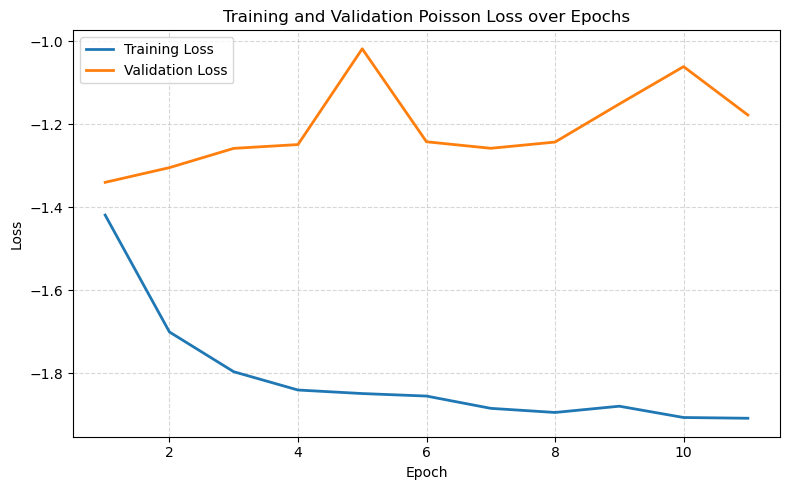

In [29]:
plot_training_history(training_history)
